In [134]:
#coding=utf-8
import requests,hashlib,types,json,threading,time,unittest,re,datetime,cx_Oracle,sys,redis,random,urllib3,os
import requests,twstock
from bs4 import BeautifulSoup
from time import sleep,ctime
from numba import jit
import pandas as pd
from json.decoder import JSONDecodeError
import MySQLdb as p
from interval import Interval
os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'
import matplotlib.pyplot as plt
from io import StringIO
from fake_useragent  import UserAgent
from collections import defaultdict
from selenium import webdriver
from urllib.parse import urlsplit
from functools import wraps
from ddt import ddt,data,unpack

In [284]:
#ipynb檔  轉成 python檔
def IpynbToPython(): 
    try:
        !jupyter nbconvert --to python 188_request_test.ipynb   
    except:
        pass
IpynbToPython()


[NbConvertApp] Converting notebook 188_request_test.ipynb to python
[NbConvertApp] Writing 79547 bytes to 188_request_test.py


In [136]:
#產生陣列帳號
def account(user,amount):
    
    account_ = []
    for i in range(1,amount,1):#去除001 ,方便測試
        account_.append(user+'{:03d}'.format(i))
    return account_
def fake_user():
    ua = UserAgent()
    global user_agent
    user_agent = ua.random
def jit_func_time(func):
    @jit
    def wrapper(*args):
        start_ = time.time()
        func(*args)
        end_ = time.time() - start_
        print("用時: {}秒".format(end_))
    return wrapper
def func_time(func):
    
    def wrapper(*args):
        start_ = time.time()
        func(*args)
        end_ = time.time() - start_
        print("用時: {}秒".format(end_))
    return wrapper


#登入password加密值, md5做4次加密完後,再和param值做最後一次md5加密
#python3 需 各參數 需把型態 變byte , 在str前加 b,或者  encode()
def md(password,param):
    m = hashlib.md5()
    m.update(password)
    sr = m.hexdigest()
    for i in range(3):
        sr= hashlib.md5(sr.encode()).hexdigest()
    rx = hashlib.md5(sr.encode()+param).hexdigest()
    return rx


def thread(function,list_name,*argv):#執行續 測是, function = 方法. args= 參數 ,list_name 為一個列表參數
    threads = []
    for name in list_name:
        t = threading.Thread(target=function,args=(name,argv))
        threads.append(t)
    for i in threads:
        i.start()
    for i in threads:
        i.join()
    sleep(1)
    del threads


cookies_ = {}#各用戶的登入用戶名 key,value存放 dict   
user_ = {}#存放 各用戶 不同的useragent
#登入%kerr%


@func_time
def Login(url,account,source='Android'):
    global user#傳給webdriver方法 當登入用戶參數
    global password#傳入 werbdriver登入的密碼 
    global post_url#非em開頭
    global em_url#em開頭
    global userAgent
    global envs#回傳redis 或 sql 環境變數   ,dev :0, 188:1
    global cookies_
    global r
    global header
    
    
    user = account#回傳 帳號 給 其他方法使用
    post_url = "http://www.%s.com"%url
    
    if url in ['dev02','dev03','fh82dev02','88hlqpdev02','teny2020dev02']:
        password = b'123qwe'#測試環境
        envs = 0
        
    elif url in  ['joy188','joy188.195353']:
        password = b'amberrd'
        post_url = "http://www2.%s.com"%url#188
        envs = 1
    elif url == 'maike2020': #合營 188
        password = b'amberrd'
        envs = 1
    
    elif url == 'fh968':#生產
        password = b'tsuta0425'
        post_url = "http://www.%s.com"%url
    
    else:
        print("輸入url有誤")

    em_url =  'http://em.%s.com'%url
    
    param = b'ba359dddc3c5dfd979169d056de72638'#'f4a30481422765de945833d10352ea18'
    
    postData = {
        "username": account,
        "password": md(password,param),
        "param" :param

    }
    
    #判斷從PC ,ios ,還世 andriod
    #global userAgent
    if source == 'Pc':
        userAgent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.100 Safari/537.36"     

    elif source == 'Android':
        userAgent = 'Mozilla/5.0 (Linux; Android 5.0; SM-G900P Build/LRX21T) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36'
    
    elif source == 'Ios':
        userAgent = 'Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like Mac OS X) AppleWebKit/604.1.38 (KHTML, like Gecko) Version/11.0 Mobile/15A372 Safari/604.1'
    
    elif source == 'Fake':#產生隨機的 useragent
        userAgent = fake_user()
    
    header = {
        'User-Agent': userAgent
    }
    
    while True:
        try:
            
            global session
            session = requests.Session()
            r = session.post(post_url+'/login/login',data = postData, headers = header,
                            )
            print(r.text)
            #print(r.json()['isSuccess'])
            if r.json()['isSuccess'] == 1:
                cookies = r.cookies.get_dict()#獲得登入的cookies 字典
                #print(cookies)
                cookies_.setdefault(account,cookies['ANVOID'])#存放用戶cookie
                #user_.setdefault(account,userAgent)#存放用戶 useragent

                t = time.strftime('%Y%m%d %H:%M:%S')
                print('登錄帳號%s,'%account+'現在時間:'+t)
                print(r.text)
                #return url
                break
            else:
                pass
                break
        except requests.exceptions.ConnectionError:
            
            print('please wait!')
            break
        except IOError:
            print('please wait!!!')
            break
        except KeyError:
            pass
            break
        except JSONDecodeError:
            break

list_ = ['hsieh001','hsieh1128000','hsiehnew01','hsieh1202000','hsieh1202001']


        
#第一個參數url: dev02,joy188,
#第二個參數帳號, 第三個參數useragent: Pc,Ios,Android

#kerr000 總代, kerr001 一代 ,kerr43453 玩家
#for i in account('kerr',10):#要產生 9個用戶,從第2個開始,  參數需待 11   , 11-2 
#for i in test_user: 
#for i in ['hsieh0508','hsieh000000','hsieh0509']:
#for i in list_:
Login('joy188.195353','trace1960','Pc')





{"errors":[],"data":[["temp value"]],"isSuccess":1}
登錄帳號trace1960,現在時間:20200715 10:35:14
{"errors":[],"data":[["temp value"]],"isSuccess":1}
用時: 1.0794315338134766秒


In [88]:
FF_().lottery_dict

{'cqssc': ['重慶', '99101'],
 'xjssc': ['新彊時彩', '99103'],
 'tjssc': ['天津時彩', '99104'],
 'hljssc': ['黑龍江', '99105'],
 'llssc': ['樂利時彩', '99106'],
 'shssl': ['上海時彩', '99107'],
 'jlffc': ['吉利分彩', '99111'],
 'slmmc': ['順利秒彩', '99112'],
 'txffc': ['騰訊分彩', '99114'],
 'btcffc': ['比特幣分彩', '99115'],
 'fhjlssc': ['吉利時彩', '99116'],
 'sd115': ['山東11選5', '99301'],
 'jx115': ['江西11選5', '99302'],
 'gd115': ['廣東11選5', '99303'],
 'sl115': ['順利11選5', '99306'],
 'jsk3': ['江蘇快3', '99501'],
 'ahk3': ['安徽快3', '99502'],
 'jsdice': ['江蘇骰寶', '99601'],
 'jldice1': ['吉利骰寶(娛樂)', '99602'],
 'jldice2': ['吉利骰寶(至尊)', '99603'],
 'fc3d': ['3D', '99108'],
 'p5': ['排列5', '99109'],
 'ssq': ['雙色球', '99401'],
 'lhc': ['六合彩', '99701'],
 'btcctp': ['快開', '99901'],
 'bjkl8': ['快樂8', '99201'],
 'pk10': ['pk10', '99202'],
 'v3d': ['吉利3D', '99801'],
 'xyft': ['幸運飛艇', '99203'],
 'fhxjc': ['鳳凰新疆', '99118'],
 'fhcqc': ['鳳凰重慶', '99117'],
 'hnffc': ['河內分彩', '99119'],
 '360ffc': ['360紛紛採', '99121'],
 '3605fc': ['360五分彩', '99122'],
 'hn5f

In [144]:
#user ='kerr'
@ddt
class TestOdd(unittest.TestCase):
    #print(user)
    @data(['key2','2'])
    @unpack
    def test_data_list(self,key,value):
        print(key,value)       
suite = unittest.TestLoader().loadTestsFromTestCase(TestOdd)
unittest.TextTestRunner().run(suite)

.

key2 2



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [53]:
class FF_(): #4.0專案
    cookies = {}
    submit_inf = {}
    # 存訪 PC前台用戶登入後的 cookie
    def __init__(self):
        self.dev_url = ['dev02','dev03','fh82dev02','88hlqpdev02','teny2020dev02']
        self.uat_url = ['joy188','joy188.195353']
        self.app_url = {'dev':['http://10.13.22.152:8199/','2D424FA3-D7D9-4BB2-BFDA-4561F921B1D5',
                               'fa0c0fd599eaa397bd0daba5f47e7151',0],
                        '188':['http://iphong.joy188.com/','f009b92edc4333fd',
                               '3bf6add0828ee17c4603563954473c1e',1]
                       }
        
        self.user_agent ={
        'Pc':"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) \
        Chrome/68.0.3440.100 Safari/537.36",
        'Ios': "Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like Mac OS X) AppleWebKit/604.1.38 \
        (KHTML, like Gecko) Version/11.0 Mobile/15A372 Safari/604.1",
        'Andorid': "Mozilla/5.0 (Linux; Android 5.0; SM-G900P Build/LRX21T) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/70.0.3538.110 Mobile Safari/537.36",
        'Fake':  UserAgent().random
        }
        self.param =  b'ba359dddc3c5dfd979169d056de72638',#固定寫死即可
        self.session = requests.Session()
        self.lottery_dict = {
        'cqssc':[u'重慶','99101'],'xjssc':[u'新彊時彩','99103'],'tjssc':[u'天津時彩','99104'],
        'hljssc':[u'黑龍江','99105'],'llssc':[u'樂利時彩','99106'],'shssl':[u'上海時彩','99107'],
        'jlffc':[u'吉利分彩','99111'],'slmmc':[u'順利秒彩','99112'],'txffc':[u'騰訊分彩','99114'],
        'btcffc':[u'比特幣分彩','99115'],'fhjlssc':[u'吉利時彩','99116'],
        'sd115':[u'山東11選5','99301'],'jx115':[u"江西11選5",'99302'],
        'gd115':[u'廣東11選5','99303'],'sl115':[u'順利11選5','99306'],'jsk3':[u'江蘇快3','99501'],
        'ahk3':[u'安徽快3','99502'],'jsdice':[u'江蘇骰寶','99601'],'jldice1':[u'吉利骰寶(娛樂)','99602'],
        'jldice2':[u'吉利骰寶(至尊)','99603'],'fc3d':[u'3D','99108'],'p5':[u'排列5','99109'],
        'ssq':[u'雙色球','99401'],'lhc':[u'六合彩','99701'],'btcctp':[u'快開','99901'],
        'bjkl8':[u'快樂8','99201'],'pk10':[u"pk10",'99202'],'v3d':[u'吉利3D','99801'],
        'xyft':[u'幸運飛艇','99203'] ,'fhxjc':[u'鳳凰新疆','99118'],'fhcqc':[u'鳳凰重慶','99117'],
         'hnffc':[u'河內分彩','99119'],'360ffc':[u'360紛紛採','99121'],'3605fc':[u'360五分彩','99122'],
        'hn5fc':[u'河內五分彩','99120'],'n3d':[u'越南3d','99124'],'np3':[u'越南福利彩','99123']
        }
    def md5(self,password,param):#4.0 登入密碼加規則
        m = hashlib.md5()
        m.update(password)
        sr = m.hexdigest()
        for i in range(3):
            sr= hashlib.md5(sr.encode()).hexdigest()
        #print(sr.encode(),param)
        rx = hashlib.md5(sr.encode()+param).hexdigest()
        return rx
    def session_post(self,request_url,request_func,postData,header):#共用 request.post方式 ,url 為動態 請求url ,source預設走PC
        global r # 會針對每個不同請求, 回覆內容作調整
        r = self.session.post(request_url+request_func,data = postData,headers=header,verify=False)
    def session_get(self,request_url,request_func,getData,header):
        global r # 會針對每個不同請求, 回覆內容作調整
        r = self.session.get(request_url+request_func,data = getData,headers=header,verify=False)
    def get_conn(self,env):#連結數據庫 env 0: dev02 , 1:188 ,2: 生產
        if env == 2:
            username = 'rdquery'
            service_name = 'gamenxsXDB'
        else:
            username = 'firefog'
            service_name = ''
        oracle_ = {'password':['LF64qad32gfecxPOJ603','JKoijh785gfrqaX67854','eMxX8B#wktFZ8V'],
        'ip':['10.13.22.161','10.6.1.41','10.6.1.31'],
        'sid':['firefog','game','']}
        conn = cx_Oracle.connect(username,oracle_['password'][env],oracle_['ip'][env]+':1521/'+
        oracle_['sid'][env]+service_name)
        return conn
    def select_joint_venture(self,conn,account):#查詢用戶 的  joint_venture身分
        with conn.cursor() as cursor:
            sql = "select joint_venture from user_customer where account = '%s'"%account
            cursor.execute(sql)
            print(sql)
            rows = cursor.fetchall()
            for i in rows:
                return i[0]
        
    def select_issue(self,conn,lottery,type_):#查詢正在銷售的 期號 ,lotttery參數,對應 lotteryid
        #today_time = '2019-06-10'#寫死 for預售中

        if type_ == 1:#一般投注
            sql = "select issue_code from game_issue where lotteryid = '%s' \
            and sysdate between sale_start_time and sale_end_time"%(self.lottery_dict[lottery][1])
        else:# 追號
            sql = "select issue_code from game_issue where lotteryid = '%s' \
            and sale_start_time > trunc(sysdate,'DD') and \
            status !=7 and period_status !=2"%(self.lottery_dict[lottery][1])
        with conn.cursor() as cursor:
            print(sql)
            cursor.execute(sql)
            rows = cursor.fetchall()
            issue_code = {}
            if lottery in ['slmmc','sl115']:#順利秒彩,順利11選5  不需 講期
                issue_code[lottery] = "1"# 獎棋給空 ,傳到 投注 
            else:
                if type_ == 1:
                    try:
                        issue_code[lottery] = rows[0][0]# rows 為一個 list 理包 一個tuple
                    except IndexError:
                        issue_code = issueCode
                        
                else:
                    issue_plan = []#追號 放期數
                    for i in rows:# i為 追號 期號 , 為一個tuple直
                        issue_plan.append(i[0])
                    issue_code[lottery] = issue_plan
            return issue_code

    def Pc_Login(self,url,user,source='Pc'):
        global post_url,em_url #後續   登入後,  各請求 需要用的
        global envs#DB 環境變數用
        global Pc_header,account
        account = user
        em_url =  'http://em.%s.com'%url
        #print(em_url)
        if url in self.dev_url:
            post_url = 'http://www.%s.com'%url
            password = b'123qwe'
            envs = 0
        elif url in self.uat_url:
            post_url = 'http://www2.%s.com'%url
            password = b'amberrd'
            envs = 1
        else:
            return('錯誤%s'%url)
        postData = {
        "username": account,
        "param" : self.param[0],#固定寫死即可
        "password": FF_().md5(password,self.param[0])# self.param 為一個 tuple (byte的關係)
        }
        Pc_header = {'User-Agent':self.user_agent[source]}
        FF_().session_post(post_url,'/login/login',postData,Pc_header)# 登入皆口
        print('登入帳號: %s'%account)
        try:
            if r.json()['isSuccess'] == 1:
                #cookies = r.cookies.get_dict()#獲得登入的cookies 字典
                if user in FF_().cookies:# 刪除原本已經存菜的key, 重新獲得
                    del FF_().cookies[user]
                FF_().cookies.setdefault(account,r.cookies.get_dict()['ANVOID'])#存放用戶cookie
                #user_.setdefault(account,userAgent)#存放用戶 useragent
                t = time.strftime('%Y%m%d %H:%M:%S')
                print('現在時間:'+time.strftime('%Y%m%d %H:%M:%S'))
                print('登入成功')
        except KeyError:
            print('登入失敗')
    
            #sleep(20)
    def plan_return(self,type_,issuelist):# 根據 type_ 判斷是不是追號, 生成動態的 動態order  
        plan_= []
        for i in range(type_):
            plan_.append({"number": 'test', "issueCode": issuelist[i], "multiple": 1})
        print(plan_)
        return plan_
    
    # 各採種 對應的 投注格式
    def submit_json(self,lottery,awardmode,isTrace,traceWinStop ,traceStopValue,type_,ball):
        if type_ != 1 :
            print(issueCode[:type_])
            order_plan = FF_().plan_return(type_,issueCode)# 生成oredr 的投注奖期 列表'
            len_order = len(order_plan)
            print(len_order)
        else:
            print(issueCode)
            order_plan = [{"number":'test',"issueCode":issueCode,"multiple":1}]# 一般投注
            len_order = 1
        if lottery == 'btcctp':
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":1,"ball":ball,"type":"chungtienpao.chungtienpao.chungtienpao","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":100.00*len_order}
        elif lottery in ['cqssc','hljssc','xjssc','tjssc','fhjlssc','fhcqc','fhxjc']:
            data_={"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":107,"ball":"-,-,-,-,-,-,-,-,龙,-","type":"longhu.longhudou.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":106,"ball":"双,大","type":"daxiaodanshuang.dxds.houer","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":105,"ball":"小","type":"daxiaodanshuang.dxds.houyi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":104,"ball":"小,双","type":"daxiaodanshuang.dxds.qianer","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":103,"ball":"小","type":"daxiaodanshuang.dxds.qianyi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":102,"ball":"小","type":"daxiaodanshuang.dxds.zonghe","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":101,"ball":"-,3,-,-,-","type":"yixing_2000.dingweidan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":100,"ball":"8","type":"houer_2000.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":9},{"id":99,"ball":"13","type":"houer_2000.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":3},{"id":98,"ball":"25","type":"houer_2000.zuxuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":97,"ball":"1,8","type":"houer_2000.zuxuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":96,"ball":"5","type":"houer_2000.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":10},{"id":95,"ball":"14","type":"houer_2000.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":5},{"id":94,"ball":"65","type":"houer_2000.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":93,"ball":"-,-,-,5,9","type":"houer_2000.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":92,"ball":"2,7","type":"housan_2000.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":91,"ball":"7","type":"housan_2000.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":90,"ball":"047","type":"housan_2000.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":89,"ball":"336","type":"housan_2000.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":88,"ball":"6","type":"housan_2000.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":87,"ball":"024","type":"housan_2000.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":86,"ball":"2,5,9","type":"housan_2000.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":85,"ball":"5,9","type":"housan_2000.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":84,"ball":"11","type":"housan_2000.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":14},{"id":83,"ball":"0","type":"housan_2000.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":10},{"id":82,"ball":"1","type":"housan_2000.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":3},{"id":81,"ball":"904","type":"housan_2000.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":80,"ball":"-,-,3,7,4","type":"housan_2000.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":79,"ball":"-,0,-,-,-","type":"yixing.dingweidan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":78,"ball":"8","type":"houer.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":9},{"id":77,"ball":"12","type":"houer.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":3},{"id":76,"ball":"48","type":"houer.zuxuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":75,"ball":"4,6","type":"houer.zuxuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":74,"ball":"8","type":"houer.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":4},{"id":73,"ball":"3","type":"houer.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":4},{"id":72,"ball":"12","type":"houer.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":71,"ball":"-,-,-,7,9","type":"houer.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":70,"ball":"8","type":"qianer.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":9},{"id":69,"ball":"10","type":"qianer.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":4},{"id":68,"ball":"37","type":"qianer.zuxuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":67,"ball":"6,8","type":"qianer.zuxuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":66,"ball":"7","type":"qianer.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":6},{"id":65,"ball":"9","type":"qianer.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":10},{"id":64,"ball":"23","type":"qianer.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":63,"ball":"6,7,-,-,-","type":"qianer.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":62,"ball":"1,2","type":"housan.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":61,"ball":"5","type":"housan.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":60,"ball":"457","type":"housan.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":59,"ball":"113","type":"housan.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":58,"ball":"1","type":"housan.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":57,"ball":"236","type":"housan.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":56,"ball":"5,6,9","type":"housan.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":55,"ball":"6,8","type":"housan.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":54,"ball":"16","type":"housan.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":14},{"id":53,"ball":"3","type":"housan.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":126},{"id":52,"ball":"9","type":"housan.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":55},{"id":51,"ball":"561","type":"housan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":50,"ball":"-,-,3,6,4","type":"housan.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":49,"ball":"1,9","type":"zhongsan.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":48,"ball":"8","type":"zhongsan.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":47,"ball":"179","type":"zhongsan.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":46,"ball":"002","type":"zhongsan.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":45,"ball":"2","type":"zhongsan.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":44,"ball":"018","type":"zhongsan.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":43,"ball":"0,4,9","type":"zhongsan.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":42,"ball":"0,9","type":"zhongsan.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":41,"ball":"20","type":"zhongsan.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":8},{"id":40,"ball":"7","type":"zhongsan.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":126},{"id":39,"ball":"042","type":"zhongsan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":38,"ball":"398","type":"zhongsan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":37,"ball":"-,7,8,2,-","type":"zhongsan.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":36,"ball":"1,2","type":"qiansan.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":35,"ball":"5","type":"qiansan.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":34,"ball":"035","type":"qiansan.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":33,"ball":"113","type":"qiansan.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":32,"ball":"9","type":"qiansan.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":31,"ball":"277","type":"qiansan.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":30,"ball":"1,7,8","type":"qiansan.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":29,"ball":"1,8","type":"qiansan.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":28,"ball":"9","type":"qiansan.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":11},{"id":27,"ball":"8","type":"qiansan.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":96},{"id":26,"ball":"0","type":"qiansan.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":25,"ball":"037","type":"qiansan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":24,"ball":"9,6,9,-,-","type":"qiansan.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":23,"ball":"5,7","type":"sixing.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":22,"ball":"3","type":"sixing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":21,"ball":"0,9","type":"sixing.zuxuan.zuxuan4","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":20,"ball":"2,9","type":"sixing.zuxuan.zuxuan6","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":19,"ball":"5,03","type":"sixing.zuxuan.zuxuan12","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":18,"ball":"3,4,5,8","type":"sixing.zuxuan.zuxuan24","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":17,"ball":"9545","type":"sixing.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":16,"ball":"-,5,5,2,3","type":"sixing.zhixuan.fushi","moneyunit":"1",
            "multiple":1,"awardMode":awardmode,"num":1},{"id":15,"ball":"8","type":"wuxing.quwei.sijifacai","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":14,"ball":"8","type":"wuxing.quwei.sanxingbaoxi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":13,"ball":"7","type":"wuxing.quwei.haoshichengshuang","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":12,"ball":"4","type":"wuxing.quwei.yifanfengshun","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":11,"ball":"0,5,8","type":"wuxing.budingwei.sanmabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":10,"ball":"2,7","type":"wuxing.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":9,"ball":"5","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":8,"ball":"9,8","type":"wuxing.zuxuan.zuxuan5","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"5,1","type":"wuxing.zuxuan.zuxuan10","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"4,01","type":"wuxing.zuxuan.zuxuan20","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"57,4","type":"wuxing.zuxuan.zuxuan30","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"6,357","type":"wuxing.zuxuan.zuxuan60","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":3,"ball":"0,1,5,6,7","type":"wuxing.zuxuan.zuxuan120","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"32077","type":"wuxing.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"1,7,1,0,6","type":"wuxing.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":1680*len_order}
        elif lottery in ['ahk3','jsk3']:
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":9,"ball":"6","type":"yibutonghao.yibutonghao.yibutonghao","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":8,"ball":"2,4","type":"erbutonghao.biaozhun.biaozhuntouzhu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"11#3","type":"ertonghaodanxuan.ertonghaodanxuan.ertonghaodanxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"55*","type":"ertonghaofuxuan.ertonghaofuxuan.ertonghaofuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"123 234 345 456","type":"sanlianhaotongxuan.sanlianhaotongxuan.sanlianhaotongxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"1,2,6","type":"sanbutonghao.biaozhun.biaozhuntouzhu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":3,"ball":"111","type":"santonghaodanxuan.santonghaodanxuan.santonghaodanxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"111 222 333 444 555 666","type":"santonghaotongxuan.santonghaotongxuan.santonghaotongxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"14","type":"hezhi.hezhi.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":18*len_order}
        elif lottery in ['sd115','jx115','gd115','sl115']:
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":37,"ball":"03","type":"quwei.normal.caizhongwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":36,"ball":"4单1双","type":"quwei.normal.dingdanshuang","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":35,"ball":"[胆02]  01,05,06,08,09,10,11","type":"xuanba.renxuanbazhongwu.dantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":34,"ball":"01 03 05 06 08 09 10 11","type":"xuanba.renxuanbazhongwu.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":33,"ball":"01,02,03,05,06,07,08,10","type":"xuanba.renxuanbazhongwu.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":32,"ball":"[胆01]  04,05,08,09,10,11","type":"xuanqi.renxuanqizhongwu.dantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":31,"ball":"01 02 04 05 06 10 11","type":"xuanqi.renxuanqizhongwu.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":30,"ball":"02,03,06,08,09,10,11","type":"xuanqi.renxuanqizhongwu.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":29,"ball":"[胆10]  01,03,06,08,09","type":"xuanliu.renxuanliuzhongwu.dantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":28,"ball":"01 04 05 07 09 10","type":"xuanliu.renxuanliuzhongwu.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":27,"ball":"01,03,05,06,09,10","type":"xuanliu.renxuanliuzhongwu.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":26,"ball":"[胆10]  01,05,07,11","type":"xuanwu.renxuanwuzhongwu.dantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":25,"ball":"01 03 06 07 09","type":"xuanwu.renxuanwuzhongwu.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":24,"ball":"03,04,06,09,11","type":"xuanwu.renxuanwuzhongwu.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":23,"ball":"[胆10]  03,08,09","type":"xuansi.renxuansizhongsi.dantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":22,"ball":"03 07 08 10","type":"xuansi.renxuansizhongsi.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":21,"ball":"02,03,04,06","type":"xuansi.renxuansizhongsi.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":20,"ball":"[胆02]  01,11","type":"xuansan.renxuansanzhongsan.renxuandantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":19,"ball":"01 07 08","type":"xuansan.renxuansanzhongsan.renxuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":18,"ball":"02,05,10","type":"xuansan.renxuansanzhongsan.renxuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":17,"ball":"[胆02]  06,08","type":"xuansan.qiansanzuxuan.zuxuandantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":16,"ball":"01 04 09","type":"xuansan.qiansanzuxuan.zuxuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":15,"ball":"03,08,09","type":"xuansan.qiansanzuxuan.zuxuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":14,"ball":"08 09 06","type":"xuansan.qiansanzhixuan.zhixuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":13,"ball":"10,01,02,-,-","type":"xuansan.qiansanzhixuan.zhixuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":12,"ball":"[胆 10] 09","type":"xuaner.renxuanerzhonger.renxuandantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":11,"ball":"09 10","type":"xuaner.renxuanerzhonger.renxuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":10,"ball":"02,06","type":"xuaner.renxuanerzhonger.renxuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":9,"ball":"[胆 01] 08","type":"xuaner.qianerzuxuan.zuxuandantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":8,"ball":"06 07","type":"xuaner.qianerzuxuan.zuxuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"02,03","type":"xuaner.qianerzuxuan.zuxuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"02 04","type":"xuaner.qianerzhixuan.zhixuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"07,02,-,-,-","type":"xuaner.qianerzhixuan.zhixuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"05","type":"xuanyi.renxuanyizhongyi.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":3,"ball":"05","type":"xuanyi.renxuanyizhongyi.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"04,-,-,-,-","type":"xuanyi.dingweidan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"02","type":"xuanyi.qiansanyimabudingwei.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":74*len_order}          
        elif lottery in ['pk10','xyft']:   
            data_ = {"gameType": lottery, "isTrace": isTrace, "traceWinStop": traceWinStop, "traceStopValue": traceStopValue, "balls": [{"id": 22, "ball": "-,-,-,-,-,01 02 03 04 05,01 02 03 04 05,01 02 03 04 05,01 02 03 04 05,01 02 03 04 05", "type": "caipaiwei.dingweidan.houfushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 50, "num": 25}, {"id": 21, "ball": "06 07 08 09 10,06 07 08 09 10,06 07 08 09 10,06 07 08 09 10,06 07 08 09 10,-,-,-,-,-", "type": "caipaiwei.dingweidan.qianfushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 50, "num": 25}, {"id": 20, "ball": "02 06 07 08 09", "type": "qianwu.zuxuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 19, "ball": "06,07,08,09,10", "type": "qianwu.zuxuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 18, "ball": "01 04 05 06 07", "type": "qianwu.zhixuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 17, "ball": "02 04 06 08 10,02 04 06 08 10,02 04 06 08 10,02 04 06 08 10,02 04 06 08 10,-,-,-,-,-", "type": "qianwu.zhixuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 240, "num": 120}, {"id": 16, "ball": "06 07 08 09", "type": "qiansi.zuxuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 15, "ball": "02,04,06,08,10", "type": "qiansi.zuxuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 10, "num": 5}, {"id": 14, "ball": "06 07 08 09", "type": "qiansi.zhixuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 13, "ball": "02 04 06 08 10,02 04 06 08 10,02 04 06 08 10,02 04 06 08 10,-,-,-,-,-,-", "type": "qiansi.zhixuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 240, "num": 120}, {"id": 12, "ball": "05 06 07", "type": "guanyaji.caiguanyaji.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 11, "ball": "01 02 03 04 05,01 02 03 04 05,01 02 03 04 05,-,-,-,-,-,-,-", "type": "guanyaji.caiguanyaji.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 120, "num": 60}, {"id": 10, "ball": "05 06 07", "type": "guanyaji.zuxuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 9, "ball": "01,02,03,04,05", "type": "guanyaji.zuxuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 20, "num": 10}, {"id": 8, "ball": "05 06 07", "type": "guanyaji.zhixuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 7, "ball": "01 02 03 04 05,01 02 03 04 05,01 02 03 04 05,-,-,-,-,-,-,-", "type": "guanyaji.zhixuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 120, "num": 60}, {"id": 6, "ball": "01 02", "type": "guanya.caiguanya.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 5, "ball": "01 02 03 04 05,01 02 03 04 05,-,-,-,-,-,-,-,-", "type": "guanya.caiguanya.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 40, "num": 20}, {"id": 4, "ball": "3,4,5,6,7,8,9,10,11", "type": "guanya.hezhi.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 100, "num": 50}, {"id": 3, "ball": "01 02", "type": "guanya.zuxuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}, {"id": 2, "ball": "01,02,03,04,05", "type": "guanya.zuxuan.fushi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 20, "num": 10}, {"id": 1, "ball": "01 02", "type": "guanya.zhixuan.danshi", "moneyunit": 1, "multiple": 1, "awardMode": awardmode, "amount": 2, "num": 1}], "orders": order_plan ,"amount":1032*len_order}
        elif lottery in ['llssc','jlffc','btcffc','slmmc']:
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":85,"ball":"-,和,-,-,-,-,-,-,-,-","type":"longhu.longhudou.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":84,"ball":"双,大","type":"daxiaodanshuang.dxds.houer","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":83,"ball":"小","type":"daxiaodanshuang.dxds.houyi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":82,"ball":"大,单","type":"daxiaodanshuang.dxds.qianer","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":81,"ball":"大","type":"daxiaodanshuang.dxds.qianyi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":80,"ball":"双","type":"daxiaodanshuang.dxds.zonghe","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":79,"ball":"-,-,-,5,-","type":"yixing.dingweidan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":78,"ball":"5","type":"houer.zuxuan.baodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":77,"ball":"11","type":"houer.zuxuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":4},{"id":76,"ball":"46","type":"houer.zuxuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":75,"ball":"2,4","type":"houer.zuxuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":74,"ball":"3","type":"houer.zhixuan.kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":14},{"id":73,"ball":"5","type":"houer.zhixuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":6},{"id":72,"ball":"49","type":"houer.zhixuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":71,"ball":"-,-,-,3,6","type":"houer.zhixuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":70,"ball":"7","type":"qianer.zuxuan.baodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":69,"ball":"8","type":"qianer.zuxuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":4},{"id":68,"ball":"27","type":"qianer.zuxuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":67,"ball":"1,6","type":"qianer.zuxuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":66,"ball":"4","type":"qianer.zhixuan.kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":12},{"id":65,"ball":"8","type":"qianer.zhixuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":64,"ball":"31","type":"qianer.zhixuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":63,"ball":"3,5,-,-,-","type":"qianer.zhixuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":62,"ball":"3,5","type":"housan.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":61,"ball":"7","type":"housan.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":60,"ball":"078","type":"housan.zuxuan.zuliudanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":59,"ball":"577","type":"housan.zuxuan.zusandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":58,"ball":"9","type":"housan.zuxuan.baodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":54},{"id":57,"ball":"125","type":"housan.zuxuan.hunhezuxuan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":56,"ball":"2,3,9","type":"housan.zuxuan.zuliu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":55,"ball":"1,2","type":"housan.zuxuan.zusan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":2},{"id":54,"ball":"26","type":"housan.zuxuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":53,"ball":"1","type":"housan.zhixuan.kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":54},{"id":52,"ball":"6","type":"housan.zhixuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":28},{"id":51,"ball":"794","type":"housan.zhixuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":50,"ball":"-,-,0,3,8","type":"housan.zhixuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":49,"ball":"5,8","type":"zhongsan.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":48,"ball":"1","type":"zhongsan.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":47,"ball":"025","type":"zhongsan.zuxuan.zuliudanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":46,"ball":"338","type":"zhongsan.zuxuan.zusandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":45,"ball":"5","type":"zhongsan.zuxuan.baodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":54},{"id":44,"ball":"149","type":"zhongsan.zuxuan.hunhezuxuan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":43,"ball":"4,5,7","type":"zhongsan.zuxuan.zuliu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":42,"ball":"0,3","type":"zhongsan.zuxuan.zusan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":2},{"id":41,"ball":"14","type":"zhongsan.zuxuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":15},{"id":40,"ball":"5","type":"zhongsan.zhixuan.kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":150},{"id":39,"ball":"15","type":"zhongsan.zhixuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":73},{"id":38,"ball":"669","type":"zhongsan.zhixuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":37,"ball":"-,6,9,1,-","type":"zhongsan.zhixuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":36,"ball":"0,9","type":"qiansan.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":35,"ball":"3","type":"qiansan.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":34,"ball":"147","type":"qiansan.zuxuan.zuliudanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":33,"ball":"599","type":"qiansan.zuxuan.zusandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":32,"ball":"2","type":"qiansan.zuxuan.baodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":54},{"id":31,"ball":"159","type":"qiansan.zuxuan.hunhezuxuan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":30,"ball":"0,5,7","type":"qiansan.zuxuan.zuliu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":29,"ball":"2,3","type":"qiansan.zuxuan.zusan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":2},{"id":28,"ball":"14","type":"qiansan.zuxuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":15},{"id":27,"ball":"4","type":"qiansan.zhixuan.kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":144},{"id":26,"ball":"2","type":"qiansan.zhixuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":6},{"id":25,"ball":"582","type":"qiansan.zhixuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":24,"ball":"0,5,8,-,-","type":"qiansan.zhixuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":23,"ball":"1,9","type":"sixing.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":22,"ball":"8","type":"sixing.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":21,"ball":"4,0","type":"sixing.zuxuan.zuxuan4","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":20,"ball":"4,5","type":"sixing.zuxuan.zuxuan6","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":19,"ball":"7,28","type":"sixing.zuxuan.zuxuan12","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":18,"ball":"1,2,5,9","type":"sixing.zuxuan.zuxuan24","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":17,"ball":"6266","type":"sixing.zhixuan.danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":16,"ball":"-,9,4,6,4","type":"sixing.zhixuan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":15,"ball":"6","type":"wuxing.quwei.sijifacai","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":14,"ball":"6","type":"wuxing.quwei.sanxingbaoxi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":13,"ball":"8","type":"wuxing.quwei.haoshichengshuang","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":12,"ball":"4","type":"wuxing.quwei.yifanfengshun","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":11,"ball":"0,3,7","type":"wuxing.budingwei.sanmabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":10,"ball":"5,8","type":"wuxing.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":9,"ball":"3","type":"wuxing.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":8,"ball":"2,7","type":"wuxing.zuxuan.zuxuan5","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"0,4","type":"wuxing.zuxuan.zuxuan10","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"4,79","type":"wuxing.zuxuan.zuxuan20","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"01,3","type":"wuxing.zuxuan.zuxuan30","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"4,078","type":"wuxing.zuxuan.zuxuan60","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":3,"ball":"1,2,5,6,8","type":"wuxing.zuxuan.zuxuan120","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"74993","type":"wuxing.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"9,9,6,4,8","type":"wuxing.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"redDiscountAmount":0,"amount":1566*len_order}
        elif lottery == 'txffc':
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":85,"ball":"-,-,-,龙,-,-","type":"longhu.longhudou.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":84,"ball":"大,双","type":"daxiaodanshuang.dxds.houer","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":83,"ball":"单","type":"daxiaodanshuang.dxds.houyi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":82,"ball":"小","type":"daxiaodanshuang.dxds.houyi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":81,"ball":"双","type":"daxiaodanshuang.dxds.houyi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":80,"ball":"大","type":"daxiaodanshuang.dxds.houyi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":79,"ball":"-,-,-,-,1","type":"yixing.dingweidan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":78,"ball":"3","type":"houer.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":9},{"id":77,"ball":"17","type":"houer.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":76,"ball":"57","type":"houer.zuxuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":75,"ball":"6,9","type":"houer.zuxuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":74,"ball":"4","type":"houer.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":12},{"id":73,"ball":"1","type":"houer.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":72,"ball":"04","type":"houer.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":71,"ball":"-,-,-,2,2","type":"houer.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":70,"ball":"7","type":"qianer.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":9},{"id":69,"ball":"17","type":"qianer.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":68,"ball":"05","type":"qianer.zuxuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":67,"ball":"5,7","type":"qianer.zuxuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":66,"ball":"3","type":"qianer.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":14},{"id":65,"ball":"13","type":"qianer.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":6},{"id":64,"ball":"94","type":"qianer.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":63,"ball":"2,9,-,-,-","type":"qianer.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":62,"ball":"0,9","type":"housan.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":61,"ball":"5","type":"housan.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":60,"ball":"346","type":"housan.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":59,"ball":"455","type":"housan.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":58,"ball":"2","type":"housan.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":57,"ball":"346","type":"housan.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":56,"ball":"1,4,7","type":"housan.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":55,"ball":"4,9","type":"housan.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":54,"ball":"2","type":"housan.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":53,"ball":"2","type":"housan.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":96},{"id":52,"ball":"1","type":"housan.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":3},{"id":51,"ball":"207","type":"housan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":50,"ball":"-,-,2,5,3","type":"housan.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":49,"ball":"2,4","type":"zhongsan.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":48,"ball":"6","type":"zhongsan.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":47,"ball":"017","type":"zhongsan.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":46,"ball":"779","type":"zhongsan.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":45,"ball":"9","type":"zhongsan.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":44,"ball":"156","type":"zhongsan.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":43,"ball":"1,4,9","type":"zhongsan.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":42,"ball":"1,6","type":"zhongsan.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":41,"ball":"20","type":"zhongsan.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":8},{"id":40,"ball":"7","type":"zhongsan.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":126},{"id":39,"ball":"17","type":"zhongsan.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":63},{"id":38,"ball":"402","type":"zhongsan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":37,"ball":"-,5,2,4,-","type":"zhongsan.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":36,"ball":"2,3","type":"qiansan.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":35,"ball":"3","type":"qiansan.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":34,"ball":"179","type":"qiansan.zuxuan.zuliudanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":33,"ball":"007","type":"qiansan.zuxuan.zusandanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":32,"ball":"3","type":"qiansan.zuxuan.baodan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":54},{"id":31,"ball":"034","type":"qiansan.zuxuan.hunhezuxuan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":30,"ball":"3,4,5","type":"qiansan.zuxuan.zuliu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":29,"ball":"0,1","type":"qiansan.zuxuan.zusan","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":28,"ball":"3","type":"qiansan.zuxuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":2},{"id":27,"ball":"6","type":"qiansan.zhixuan.kuadu","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":144},{"id":26,"ball":"16","type":"qiansan.zhixuan.hezhi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":69},{"id":25,"ball":"338","type":"qiansan.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":24,"ball":"8,8,2,-,-","type":"qiansan.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":23,"ball":"4,6","type":"sixing.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":22,"ball":"2","type":"sixing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":21,"ball":"5,0","type":"sixing.zuxuan.zuxuan4","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":20,"ball":"6,7","type":"sixing.zuxuan.zuxuan6","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":19,"ball":"9,04","type":"sixing.zuxuan.zuxuan12","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":18,"ball":"3,4,5,8","type":"sixing.zuxuan.zuxuan24","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":17,"ball":"8360","type":"sixing.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":16,"ball":"-,8,8,3,4","type":"sixing.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":15,"ball":"6","type":"wuxing.quwei.sijifacai","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":14,"ball":"6","type":"wuxing.quwei.sanxingbaoxi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":13,"ball":"8","type":"wuxing.quwei.haoshichengshuang","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":12,"ball":"6","type":"wuxing.quwei.yifanfengshun","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":11,"ball":"3,4,8","type":"wuxing.budingwei.sanmabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":10,"ball":"3,7","type":"wuxing.budingwei.ermabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":9,"ball":"6","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":8,"ball":"3","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"4","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"2","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"6","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"1","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":3,"ball":"5","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"0","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"8","type":"wuxing.budingwei.yimabudingwei","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":1594*len_order}
        elif lottery == 'bjkl8':
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":8,"ball":"05,25,42,43,51,67,80","type":"renxuan.putongwanfa.renxuan7","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"12,28,54,64,69,80","type":"renxuan.putongwanfa.renxuan6","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"24,29,39,50,71","type":"renxuan.putongwanfa.renxuan5","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"03,14,51,57","type":"renxuan.putongwanfa.renxuan4","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"16,52,79","type":"renxuan.putongwanfa.renxuan3","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":3,"ball":"48,74","type":"renxuan.putongwanfa.renxuan2","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"25","type":"renxuan.putongwanfa.renxuan1","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"中","type":"quwei.panmian.quweib","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":16*len_order}
        elif lottery in ['v3d','fc3d']:
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":30,"ball":"-,1,-","type":"yixing.dingweidan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":29,"ball":"6","type":"houer.zuxuan.zuxuanbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":28,"ball":"12","type":"houer.zuxuan.zuxuanhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":3},{"id":27,"ball":"28","type":"houer.zuxuan.zuxuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":26,"ball":"6,8","type":"houer.zuxuan.zuxuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":25,"ball":"1","type":"houer.zhixuan.zhixuankuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":18},{"id":24,"ball":"6","type":"houer.zhixuan.zhixuanhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":7},{"id":23,"ball":"58","type":"houer.zhixuan.zhixuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":22,"ball":"-,4,3","type":"houer.zhixuan.zhixuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":21,"ball":"3","type":"qianer.zuxuan.zuxuanbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":20,"ball":"11","type":"qianer.zuxuan.zuxuanhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":4},{"id":19,"ball":"05","type":"qianer.zuxuan.zuxuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":18,"ball":"1,7","type":"qianer.zuxuan.zuxuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":17,"ball":"1","type":"qianer.zhixuan.zhixuankuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":18},{"id":16,"ball":"11","type":"qianer.zhixuan.zhixuanhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":8},{"id":15,"ball":"23","type":"qianer.zhixuan.zhixuandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":14,"ball":"1,0,-","type":"qianer.zhixuan.zhixuanfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":13,"ball":"4,7","type":"sanxing.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":12,"ball":"3","type":"sanxing.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":11,"ball":"235","type":"sanxing.zuxuan.zuliudanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":10,"ball":"388","type":"sanxing.zuxuan.zusandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":9,"ball":"1","type":"sanxing.zuxuan.zuxuanbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":54},{"id":8,"ball":"248","type":"sanxing.zuxuan.hunhezuxuan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":7,"ball":"3,7,8","type":"sanxing.zuxuan.zuliu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":6,"ball":"5,7","type":"sanxing.zuxuan.zusan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":2},{"id":5,"ball":"6","type":"sanxing.zuxuan.zuxuanhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":6},{"id":4,"ball":"6","type":"sanxing.zhixuan.kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":144},{"id":3,"ball":"25","type":"sanxing.zhixuan.hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":6},{"id":2,"ball":"126","type":"sanxing.zhixuan.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"4,4,3","type":"sanxing.zhixuan.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":610*len_order}
        elif lottery in ['jsdice','jldice1','jldice2']:
            data_ = {"gameType":lottery,"isTrace":isTrace,"multiple":1,"trace":1,"amount":"520.00","balls":[{"ball":"大","id":0,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"daxiao.daxiao"},{"ball":"单","id":1,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"danshuang.danshuang"},{"ball":"66*","id":2,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"ertonghaofuxuan.ertonghaofuxuan"},{"ball":"55*","id":3,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"ertonghaofuxuan.ertonghaofuxuan"},{"ball":"44*","id":4,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"ertonghaofuxuan.ertonghaofuxuan"},{"ball":"666","id":5,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaodanxuan.santonghaodanxuan"},{"ball":"555","id":6,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaodanxuan.santonghaodanxuan"},{"ball":"444","id":7,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaodanxuan.santonghaodanxuan"},{"ball":"333","id":8,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaodanxuan.santonghaodanxuan"},{"ball":"222","id":9,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaodanxuan.santonghaodanxuan"},{"ball":"111","id":10,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaodanxuan.santonghaodanxuan"},{"ball":"111 222 333 444 555 666","id":11,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"santonghaotongxuan.santonghaotongxuan"},{"ball":"33*","id":12,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"ertonghaofuxuan.ertonghaofuxuan"},{"ball":"22*","id":13,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"ertonghaofuxuan.ertonghaofuxuan"},{"ball":"11*","id":14,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"ertonghaofuxuan.ertonghaofuxuan"},{"ball":"小","id":15,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"daxiao.daxiao"},{"ball":"双","id":16,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"danshuang.danshuang"},{"ball":"17","id":17,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"16","id":18,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"15","id":19,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"14","id":20,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"13","id":21,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"12","id":22,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"11","id":23,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"10","id":24,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"9","id":25,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"8","id":26,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"7","id":27,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"6","id":28,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"5","id":29,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"4","id":30,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"hezhi.hezhi"},{"ball":"5,6","id":31,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"4,6","id":32,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"4,5","id":33,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"3,6","id":34,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"3,5","id":35,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"3,4","id":36,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"2,6","id":37,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"2,5","id":38,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"2,4","id":39,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"2,3","id":40,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"1,6","id":41,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"1,5","id":42,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"1,4","id":43,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"1,3","id":44,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"1,2","id":45,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"erbutonghao.erbutonghao"},{"ball":"6","id":46,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"yibutonghao.yibutonghao"},{"ball":"5","id":47,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"yibutonghao.yibutonghao"},{"ball":"4","id":48,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"yibutonghao.yibutonghao"},{"ball":"3","id":49,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"yibutonghao.yibutonghao"},{"ball":"2","id":50,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"yibutonghao.yibutonghao"},{"ball":"1","id":51,"moneyunit":1,"multiple":1,"amount":10,"num":5,"type":"yibutonghao.yibutonghao"}],"orders":order_plan }
        elif lottery == 'p5':
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":38,"ball":"2","type":"p3houer.zuxuan.zuxuanp3houerbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":37,"ball":"6","type":"p3houer.zuxuan.zuxuanp3houerhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":3},{"id":36,"ball":"38","type":"p3houer.zuxuan.zuxuanp3houerdanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":35,"ball":"0,7","type":"p3houer.zuxuan.zuxuanp3houerfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":34,"ball":"9","type":"p3houer.zhixuan.zhixuanp3houerkuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":2},{"id":33,"ball":"5","type":"p3houer.zhixuan.zhixuanp3houerhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":6},{"id":32,"ball":"02","type":"p3houer.zhixuan.zhixuanp3houerdanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":31,"ball":"-,2,7","type":"p3houer.zhixuan.zhixuanp3houerfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":30,"ball":"2","type":"p3qianer.zuxuan.zuxuanp3qianerbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":29,"ball":"7","type":"p3qianer.zuxuan.zuxuanp3qianerhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":4},{"id":28,"ball":"67","type":"p3qianer.zuxuan.zuxuanp3qianerdanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":27,"ball":"2,5","type":"p3qianer.zuxuan.zuxuanp3qianerfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":26,"ball":"3","type":"p3qianer.zhixuan.zhixuanp3qianerkuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":14},{"id":25,"ball":"18","type":"p3qianer.zhixuan.zhixuanp3qianerhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":24,"ball":"48","type":"p3qianer.zhixuan.zhixuanp3qianerdanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":23,"ball":"7,2,-","type":"p3qianer.zhixuan.zhixuanp3qianerfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":22,"ball":"3,8","type":"p3sanxing.budingwei.ermabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":21,"ball":"1","type":"p3sanxing.budingwei.yimabudingwei","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":20,"ball":"279","type":"p3sanxing.zuxuan.p3zuliudanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":19,"ball":"229","type":"p3sanxing.zuxuan.p3zusandanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":18,"ball":"6","type":"p3sanxing.zuxuan.p3zuxuanbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":54},{"id":17,"ball":"179","type":"p3sanxing.zuxuan.p3hunhezuxuan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":16,"ball":"1,3,9","type":"p3sanxing.zuxuan.p3zuliu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":15,"ball":"7,8","type":"p3sanxing.zuxuan.p3zusan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":2},{"id":14,"ball":"23","type":"p3sanxing.zuxuan.p3zuxuanhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":4},{"id":13,"ball":"0","type":"p3sanxing.zhixuan.p3kuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":10},{"id":12,"ball":"27","type":"p3sanxing.zhixuan.p3hezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":11,"ball":"249","type":"p3sanxing.zhixuan.p3danshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":10,"ball":"7,1,9","type":"p3sanxing.zhixuan.p3fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":9,"ball":"-,-,2,-,-","type":"p5yixing.dingweidan.fushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":8,"ball":"7","type":"p5houer.zuxuan.zuxuanp5houerbaodan","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":9},{"id":7,"ball":"9","type":"p5houer.zuxuan.zuxuanp5houerhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":5},{"id":6,"ball":"03","type":"p5houer.zuxuan.zuxuanp5houerdanshi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":5,"ball":"3,4","type":"p5houer.zuxuan.zuxuanp5houerfushi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":4,"ball":"4","type":"p5houer.zhixuan.zhixuanp5houerkuadu","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":12},{"id":3,"ball":"14","type":"p5houer.zhixuan.zhixuanp5houerhezhi","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":5},{"id":2,"ball":"64","type":"p5houer.zhixuan.zhixuanp5houerdanshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"-,-,-,7,4","type":"p5houer.zhixuan.zhixuanp5houerfushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":342*len_order}
        elif lottery == 'ssq':
            data_ = {"gameType":lottery,"isTrace":isTrace,"traceWinStop":traceWinStop,"traceStopValue":traceStopValue,"balls":[{"id":3,"ball":"D:18_T:01,03,06,26,33+13","type":"biaozhuntouzhu.biaozhun.dantuo","moneyunit":1,"multiple":1,"awardMode":awardmode,"num":1},{"id":2,"ball":"08,17,19,22,24,33+07","type":"biaozhuntouzhu.biaozhun.danshi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1},{"id":1,"ball":"10,15,18,23,24,31+05","type":"biaozhuntouzhu.biaozhun.fushi","moneyunit":"1","multiple":1,"awardMode":awardmode,"num":1}],"orders":order_plan ,"amount":6*len_order}
        return data_
    def Account_Cookie(self,user):# 用戶登入 的cookie 值
        account_cookie  = FF_().cookies[user]#用戶登入的cookie
        Pc_header['Cookie'] =  'ANVOID='+ account_cookie# 在header增加用戶登入cookie
        return Pc_header
    def Pc_Submit(self,user,lottery,awardmode,type_,stop="",ball=""):#PC投注
        Pc_header =FF_().Account_Cookie(user)# 用戶 header 增加登入 
        global issueCode# PC 和APP 投注共用 旗號參數
        #print(FF_().submit_inf)
        if type_ == 1:# 一般投注
            isTrace =  0 
            traceWinStop = 0
            traceStopValue = -1
        else:#追號
            if stop == "":# 預設追種即停
                traceWinStop=1
                traceStopValue=1
                print ('追中即停')
            else:
                traceWinStop=0
                traceStopValue=-1
                print('追中不停')
            isTrace=1
        if FF_().submit_inf == {}:# 初始化投注. 一定會呼叫奖期, 不燃會報錯
            issueCode = FF_().select_issue(FF_().get_conn(envs),lottery,type_)[lottery]# 奖期api , 為一個dict ,key為採種
            '''
            if user in list(FF_().submit_inf.values())[0]:# 針對快開  一期只能投住一筆
                print ( list(FF_().submit_inf.values())[0])
                print('該用戶投住過,休息30s')
                sleep(30)
                del FF_().submit_inf[issueCode]
                FF_().submit_user = []
                issueCode = FF_().select_issue(FF_().get_conn(envs),lottery,type_)[lottery]
                #return "%s 用戶,該期: %s 已經投注過,換下期"%(user,issueCode)
                '''
            #issueCode = FF_().submit_inf[lottery]# 這段 紀錄上個有抓到奖期的資訊
        postData = FF_().submit_json(lottery,awardmode,isTrace,traceWinStop ,traceStopValue,type_,ball)
        FF_().session_post(em_url,'/gameBet/%s/submit'%lottery,json.dumps(postData),Pc_header)
        print('%s投注,彩種: %s'%(user,self.lottery_dict[lottery][0]))
        print( r.json()['isSuccess'])
        #try: # 投注成功才會有  r.json()
        if r.json()['isSuccess'] == 1:# 頭住成功
            FF_().submit_inf[lottery] = issueCode # 投注成功  ,紀錄 彩種: 奖期,避免一直要DB 奖期
            print( FF_().submit_inf)
            print('投注成功 ,訂單id: %s'%(r.json()['data']['projectId']))
        else:#w投注失敗
            try:
                print(r.json()['msg'])
            except:
                sleep(10)
            if "您本期已进行投注" in  r.json()['msg']:
                sleep(30)
            elif "已截止销售" in r.json()['msg']:
                pass
            print('更新奖期')
            try:
                issueCode = FF_().select_issue(FF_().get_conn(envs),lottery,type_)[lottery]# 投注失敗 奖期再update一次
            except:
                sleep(3)
            #print(r.json()['msg'])
        '''
        except:
            print(r.text)
            print('更新奖期')
            issueCode = FF_().select_issue(FF_().get_conn(envs),lottery,type_)[lottery]# 投注失敗 奖期再update一次
        '''
    def Third_Home(self):# 第三方連線
        Pc_header =FF_().Account_Cookie()
        getData = ""
        FF_().session_get(post_url,'/lc/home',getData,header)
        soup = BeautifulSoup(r.text,'lxml')
        print(soup.find_all('strong',{'id_':'_userName'}))
class App(FF_):
    token = defaultdict(list)
    #token = {}# APP 登入後, 各鳩口 會需要用到 , 列表分表包  token和userid
    def App_LotteryData(self,App_account,lottery):#APP投注會呼叫此皆口
        now = int(time.time()*1000)#現再投注時間戳
        token = App().token[App_account][0]
        userid = App().token[App_account][1]
        data={"head":{"sessionId":token},
        "body":{"param":{"CGISESSID":token,
        "lotteryId":self.lottery_dict[lottery][1],"chan_id":1,"userid":userid,"money": 1,
        "redDiscountTotal":0,"issue":issueCode,"issueName":"2020077","isFirstSubmit":0,
        "list":[{"methodid":"65_72_105","codes":"1.01","nums":1,"fileMode":0,"mode":1,"times":1,
        "money":1,"awardMode":2}],"traceIssues":"","traceTimes":"","traceIstrace":0,
        "channelVersion":"1.0.23.0013","saleTime":now,"userIp":168627224,"channelId":202,"traceStop":0,
        "app_id":9,"come_from":"3","appname":"1"}}}        
        return data 
    def App_Login(self,env,App_account,joint_=0):# 預設走  一般 joint_venture 0
        global envs
        envs = self.app_url[env][3]# 環境DB 參數
        #joint_venture = FF_().select_joint_venture(FF_().get_conn(envs),account)
        #print(joint_venture)
        postdata ={"head": {"sessionId": ''},
        "body": {"param": {
        "username":  App_account+"|"+ self.app_url[env][1],"loginpassSource":self.app_url[env][2],
        "appCode": 1,"uuid": self.app_url[env][1],
        "loginIp": 2130706433,"device": 2,"app_id": 9,"come_from": "3","appname": "1","jointVenture": joint_
        }}}
        global App_header# 後續 APP 接口使用
        App_header = {'User-Agent':self.user_agent['Pc']}
        App_header['Content-Type'] = 'application/json'
        App().session_post(self.app_url[env][0],'front/login',json.dumps(postdata),App_header)# 登入皆口
        status = r.json()['head']['status']
        token = r.json()['body']['result']['token']
        userid = r.json()['body']['result']['userid']
        if App_account in App().token:
            pass
        else:
            App.token.setdefault(App_account,[]).append(token)
            App.token.setdefault(App_account,[]).append(userid)
        if status == 0:
            print ('登入成功')
        else:
            print(r.json())
            print('登入失敗')    
    
    def App_Submit(self,lottery,App_account,type_=1):# APP投注 不先要奖期. 用投注結果 來確認(避免多投注,會一直要DB資料)
        global issueCode#PC和APP共用
        if FF_().submit_inf == {}:# 初始化投注. 一定會呼叫奖期, 不燃會報錯
            issueCode = FF_().select_issue(FF_().get_conn(envs),lottery,type_)[lottery]# 奖期api , 為一個dict ,key為採種
        else:
            issueCode = FF_().submit_inf[lottery]# 這段 紀錄上個有抓到奖期的資訊
        postdata = App().App_LotteryData(App_account,lottery)
        App().session_post(self.app_url[env_][0],'game/buy',json.dumps(postdata),App_header)# 投注皆口
        status = r.json()['head']['status']# 投注回復狀態 判斷
        print (status)
        if status == 0:
            orderid = r.json()['body']['result']['orderId']
            print (orderid)
            print('投注成功')
            FF_().submit_inf[lottery] = issueCode# 投注成功  ,紀錄 彩種: 奖期,避免一直要DB 奖期
        elif status == 201004:
            issueCode = FF_().select_issue(FF_().get_conn(envs),lottery,1)[lottery]#type 目前寫死 1 , 一般投注
            print (issueCode)
            print('期號需確認,重新要一次奖期: %s'%issueCode)
            issueCode = FF_().submit_inf[lottery]
            #sleep(10)
        else:
            print('投注失敗,待確認')

In [90]:
FF_().Pc_Login('dev02','hsieh001')

登入帳號: hsieh001
現在時間:20200820 14:48:41
登入成功


In [3]:
class DG(FF_):
    def __init__(self,username):
        self.data_type ={
        'login':
        ['玩家登陆',{"token": "402a5c318a105c2b47368c6726b74869","random": "123456","lang": "cn",
        "member": {"username": username,"password": "123456"}}],
        'signup':
        ['注册新玩家',{"token":"402a5c318a105c2b47368c6726b74869","random":123456,"data":"A",
        "member":{"username":"TEST10000","password":"e10adc3949ba59abbe56e057f20f883e", 
        "currencyName":"CNY","winLimit":1000 }}],
        'free':
        ['玩家登陆试玩',{"token":"402a5c318a105c2b47368c6726b74869","random":"123456", "lang":"en"}],
        'update':
        ['修改玩家信息',{"token":"402a5c318a105c2b47368c6726b74869", "random":"123456", 
        "member":{"username":"TEST10000","password":"e10adc3949ba59abbe56e057f20f883e",
        "winLimit":0.0,"status":1}}],
        'getBalance':
        ['获取玩家余额',{"token":"402a5c318a105c2b47368c6726b74869","random":"123456","member":
        {"username":"TEST10000"}}],
        'transfer':
        ['玩家存取款',{"token":"402a5c318a105c2b47368c6726b74869","random":"123456",  "data":"202007231356256", 
        "member":{"username":"TEST10000","amount":100}}],
        'checkTransfer':
        ['检查存取款操作是否成功',{ "token":"402a5c318a105c2b47368c6726b74869","random":"123456", 
        "data":"202007230956256"}],
        'updateLimit':
        ['修改玩家限红组',{ "token":"402a5c318a105c2b47368c6726b74869", "random":"123456","data":"B", 
        "member":{"username":"TEST10000"}}],
        'getReport': 
        ['抓取注单报表',{"token":"59c78f14ae96a00bc907c2adaffc7938","random":"5bb96d22327eba3609438c955a903b4d"}],
        'onlineReport':
        ['获取在线玩家',{"token":"402a5c318a105c2b47368c6726b74869","random":"123456"}],
        'offline':
        ['踢人下线',{"token":"402a5c318a105c2b47368c6726b74869","random":"123456",  "list":[] }],
        }
    def DG_Test(username,type_):# DG 皆口  
    #key為各街口參數 ,  value 為各皆口 data參數
        urllib3.disable_warnings()#解決 會跳出 request InsecureRequestWarning問題
        test_header = { 
            "Content-Type": "application/json",
            'User-Agent':FF_().user_agent['Pc']
        }
        test_data = DG(username).data_type[type_][1]
        if type_ in ['transfer','checkTransfer']:
            url = 'account'
        elif type_ in ['updateLimit','getReport']:
            url = 'game'
        else:
            url = 'user'
        url = '/%s/%s/DGTE01011T'%(url,type_)
        print(url)
        FF_().session_post('https://api.dg99web.com',url,json.dumps(test_data),test_header)
        print('連線狀態: %s '%r.status_code)
        print('回覆內容: %s'%r.json())

for item in DG(username='hsieh001').data_type.keys():
    print(item+DG(username='hsieh001').data_type[item][0])
    DG.DG_Test(username='hsieh001',type_=item)
#DG.DG_Test(username='hsieh001',type_='login')


login玩家登陆
/user/login/DGTE01011T
連線狀態: 200 
回覆內容: {'codeId': 400, 'token': '402a5c318a105c2b47368c6726b74869', 'lang': 'cn', 'random': '123456', 'data': '61.220.138.45', 'member': {'username': 'hsieh001', 'password': '123456', 'userLevel': 6}}
signup注册新玩家
/user/signup/DGTE01011T
連線狀態: 200 
回覆內容: {'codeId': 400, 'token': '402a5c318a105c2b47368c6726b74869', 'random': '123456', 'data': '61.220.138.45'}
free玩家登陆试玩
/user/free/DGTE01011T
連線狀態: 200 
回覆內容: {'codeId': 400, 'token': '402a5c318a105c2b47368c6726b74869', 'lang': 'en', 'random': '123456', 'data': '61.220.138.45'}
update修改玩家信息
/user/update/DGTE01011T
連線狀態: 200 
回覆內容: {'codeId': 400, 'token': '402a5c318a105c2b47368c6726b74869', 'random': '123456', 'data': '61.220.138.45'}
getBalance获取玩家余额
/user/getBalance/DGTE01011T
連線狀態: 200 
回覆內容: {'codeId': 400, 'token': '402a5c318a105c2b47368c6726b74869', 'random': '123456', 'data': '61.220.138.45', 'member': {'username': 'TEST10000'}}
transfer玩家存取款
/account/transfer/DGTE01011T
連線狀態: 200 
回覆內容: {'

In [213]:
test = {}
a = [1,2]
b = [3,4]
for key,value in zip(a,b):
    test[key] = value
test

{1: 3, 2: 4}

In [217]:
class GameBox(FF_):
    #appId = "HvMOR9fH"
    def __init__(self,clientId='',username='',app_Id='',member_Id='',password='',amount=''):
        self.data_type = {"token":['管理/獲取令牌',
        "/oauth/token?client_id=admin&client_secret=gameBox-2020-08-11*admin&username=admin&password=gameBox-2020-08-11*admin&grant_type=password&scope=all"
        ,""],
        "createApp":["管理/創建APP帳號",
        "/admin/client/createApp",{
        "clientId": clientId,"clientSecret": "string","dec": "string","email": "%s@gmail.com"%clientId,
        "ipWhitelist": "61.220.138.45","supplierAccountDTOList": [
        {"apiKey": "string","apiUrl": "https://api.dg99web.com","password": password,
        "supplierType": "string","username": "string"}]
        }],
        "updateIpWhitelist":["管理/修改客户的ip白名单",
        "/admin/client/updateIpWhitelist?appId=%s&ipWhitelist=61.220.138.45"%app_Id,""],
        "updateSupplierAccount":["管理/修改三方账号信息",
        "/admin/client/updateSupplierAccount?appId=%s&type=1"%app_Id,{
        "apiKey": "1566e8efbdb444dfb670cd515ab99fda","apiUrl": "https://api.dg99web.com","password": "qwe123",
        "username": clientId}],
        "signUp":["客戶/註冊",
        "/api/member/signUp?agent_name=%s"%clientId,{
        "member": {"currencyName": "CNY", "password": password, "username": username, "winLimit": 0 },
        "oddType": "A" }],
        "login":["客戶/登入",
        "/api/member/login?agent_name=%s"%clientId,{
        "lang": "CNY","member": {"password": password, "username": username}}],
        "freeLogin":["客戶/試玩登入",
        "/api/member/freeLogin?agent_name=%s"%clientId,{"lang": "string"}],
        "update":["客戶/修改会员信息",
        "/api/member/update?agent_name=%s"%clientId,{
        "member": {"status": 0, "winLimit": 0,"password": password, "username": username }}],
        "balance":['客戶/获取会员余额接口',
        "/api/member/balance?agent_name=%s"%clientId,
        {"member": {"username": username,}}],
        "transfer":["客戶/会员存取款接口",
        "/api/member/transfer?agent_name=%s"%clientId,
        {"billNo": '%s'%random.randint(1,1000000000),"member": {"amount": "100","username": username,}}],
        "checkTransfer":["客戶/检查存取款操作是否成功",
        "/api/member/checkTransfer?agent_name=%s"%clientId,
         {"member": {"billNo": username}},],
        "updateLimit":['客戶/修改会员限红组',
        "/api/member/updateLimit?agent_name=%s"%clientId,
        {"member": {"username": username},"oddType": "A"}],
        "checkOnline":["客戶/查询玩家在线状态",
        "/api/member/checkOnline?agent_name=%s"%clientId,
        {"member": {"username": username.upper()}}],
        "onlineCount":['客戶/查询在线玩家数量','/api/member/onlineCount?agent_name=%s'%clientId
        ,""],
        "offline":['客戶/踢人','/api/member/offline?agent_name=%s'%clientId,
        {"member": {"memberId":member_Id}}]               
         }
    def GameBox_Con(client_id):# 連線 mysql
        db = p.connect(
        host = '43.240.38.15',
        port = 21330,
        user = 'amberrd',
        passwd = 'Gvmz8DErUcHgMgQh',
        )
        cur = db.cursor()
        sql = "SELECT app_id,app_key FROM test.t_client where client_id = '%s'"%client_id# clien_id 找出 id,key
        #print(sql)
        cur.execute(sql)
        client_detail = {}
        rows = cur.fetchall()
        for i in rows:
            client_detail[client_id] = i
        print(client_detail)
        return client_detail
        cur.close()
    
    # type_: 是用function 名, clientId = client帳號
    def GameBox_test(type_,clientId,username,client_detail,password):
        try:
            global access_token,token_type,pc_url,dr,memberId,appId
            #client_detail = GameBox.GameBox_Con(clientId)
            #username = 'kerr%s'%random.randint(1,1000)
            data_ =  GameBox(clientId=clientId,username=username,password=password).data_type[type_]
            print(type_,data_[0])
            #url_content = data_[1]
            test_header = { 
                "Content-Type": "application/json",
                'User-Agent':FF_().user_agent['Pc']
            }
            appId = client_detail[clientId][0]
            appKey = client_detail[clientId][1]
            #print(appId,appKey)
            if type_ in ['createApp','updateIpWhitelist','updateSupplierAccount']:
                test_header['Authorization'] = token_type + " %s"%access_token
                if type_!= 'createApp':#另外兩個  需 在產 global appId
                    data_ =  GameBox(clientId,username,app_Id=appId).data_type[type_]
            #elif type_ in ['signUp','login','freeLogin','checkOnline','balance','transfer','updateLimit']:
            else:#客戶端
                if type_ == 'checkOnline':
                    dr = webdriver.Chrome(executable_path=r'C:\python3\Scripts\jupyter_test\chromedriver_83.exe')
                    dr.get(pc_url)# 用 瀏覽器登入, 才能 獲得 memberid
                elif type_ == 'offline':# 踢人 ,在把 global memberid 傳還init
                    data_ =  GameBox(clientId,username,member_Id=memberId).data_type[type_]
                time_ = int(time.time())
                test_header['appId'] = appId #appId#"930ea5d5a258f4f"#appId
                test_header['nonce-str'] = "ibuaiVcKdpRxkhJA"
                #test_header['appKey'] = "316489e115371ed23808a9ce2ee094a38ca4411a"
                test_header['timestamp'] = str(time_)#"1597729724"#str(time_)
                m = hashlib.md5()
                str_ = "appId=%s&nonce-str=ibuaiVcKdpRxkhJA&timestamp=%s&appKey=%s"%(appId,str(time_),appKey)
                #print(str_)
                #print(str_,type(str_))
                m.update(str_.encode())
                str_md = m.hexdigest()
                test_header['signature'] = str_md.upper()#'9A0A8659F005D6984697E2CA0A9CF3B7'#str_md.upper()
            url_content = data_[1]
            data = data_[2]
            #print(test_header)
            FF_().session_post('http://43.240.38.15:21080',url_content,json.dumps(data),test_header)
            r_json = r.json()
            print('連線狀態: %s'%r.status_code)
            print(r_json)

            if type_ == 'token':
                access_token = r_json['access_token']
                token_type = r_json['token_type']
            elif type_ == 'checkOnline':
                memberId = r_json['data']['member']['memberId']
            elif type_ == 'login':
                pc_url = r_json['data']['pc']# 拿來 checkOnline  要先登入,才能  獲得memberId
            
        except KeyError as e:
            error_msg = 'KeyError : %s'%e
            print(error_msg)
            if 'memberId' in error_msg:
                for i in range(10):
                    print('瀏覽器登入')
                    while True:
                        try:
                            sleep(5)
                            FF_().session_post('http://43.240.38.15:21080',url_content,json.dumps(data),test_header)
                            
                            memberId = (r_json['data']['member']['memberId'])
                            break
                        except:
                            print('繼續等候登入')
        except NameError as e:
            error_msg  = "NameError : %s"%e
            print(error_msg)
            if 'token_type' in error_msg:# 需要從新獲取令牌
                print('需從新獲取令牌 token')
                url_content="/oauth/token?client_id=admin&client_secret=gameBox-2020-08-11*admin&username=admin&password=gameBox-2020-08-11*admin&grant_type=password&scope=all"
                test_header = { 
                "Content-Type": "application/json",
                'User-Agent':FF_().user_agent['Pc']
                }
                FF_().session_post('http://43.240.38.15:21080',url_content,'',test_header) 
                access_token = r.json()['access_token']
                token_type = r.json()['token_type']
clientId = 'DGTE01011T'
client_detail = GameBox.GameBox_Con(clientId)# 登入DB
for i in range(1):
    GameBox.GameBox_test(type_='login',clientId=clientId,username='kerr{:03d}'.format(i),
                         client_detail=client_detail,password='123qwe')

{'DGTE01011T': ('eiaitZQq', '82262766bda87cfb64022f8f90825a3119fbbbfa')}
login 客戶/登入
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {'pc': 'https://pc.dg0.co/direct1.html?token=1b4a5304063f40e6ad5af52ebb528fd0&language=CNY', 'phone': 'https://dg-asia.52krddm.com/dgnew/pc/direct1.html?token=1b4a5304063f40e6ad5af52ebb528fd0&language=CNY', 'app': 'http://app.wechat668.com/download/cn.html?t=1b4a5304063f40e6ad5af52ebb528fd0&language=CNY'}}


In [194]:
# 執行續 併發
threads = []
user = 'kerr'
func_name = 'signUp'
for i in range(21,40,1):
    t = threading.Thread(target=GameBox.GameBox_test,args=(func_name,clientId,'kerr{:03d}'.format(i),
    client_detail,'123qwe'))
    threads.append(t)
for i in threads:
    i.start()
for i in threads:
    i.join()

signUpsignUp 客戶/註冊 客戶/註冊

signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊signUp
 signUp客戶/註冊 客戶/註冊

signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
signUp signUp 客戶/註冊
客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
signUp 客戶/註冊
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
連線狀態: 200
{'

In [22]:
GameBox().data_type.keys()

dict_keys(['token', 'createApp', 'updateIpWhitelist', 'updateSupplierAccount', 'signUp', 'login', 'freeLogin', 'update', 'balance', 'transfer', 'checkTransfer', 'updateLimit', 'checkOnline', 'onlineCount', 'offline'])

In [33]:
dr.quit()# 瀏覽器關閉

In [23]:
client_list =[ 'signUp', 'login', 'freeLogin', 'update', 'balance', 'transfer', #客戶端 function name
'checkTransfer', 'updateLimit', 'checkOnline', 'onlineCount', 'offline']
username = 'kerr%s'%random.randint(1,1000)# 建立一個 隨機用戶名
print(username)
client_detail = GameBox.GameBox_Con(clientId)# 登入DB, 拿取 appkey,appid
for i in client_list:
    GameBox.GameBox_test(type_=i,clientId='DGTE01011T',username=username,client_detail=client_detail)
dr.quit()

kerr45
{'DGTE01011T': ('eiaitZQq', '82262766bda87cfb64022f8f90825a3119fbbbfa')}
signUp 客戶/註冊
appId=eiaitZQq&nonce-str=ibuaiVcKdpRxkhJA&timestamp=1597829650&appKey=82262766bda87cfb64022f8f90825a3119fbbbfa
{'Content-Type': 'application/json', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)         Chrome/68.0.3440.100 Safari/537.36', 'appId': 'eiaitZQq', 'nonce-str': 'ibuaiVcKdpRxkhJA', 'timestamp': '1597829650', 'signature': 'F31FB0837B1D5DCB2E04616406D6220C'}
連線狀態: 200
{'code': 20000, 'message': '操作成功', 'data': {}}
{'DGTE01011T': ('eiaitZQq', '82262766bda87cfb64022f8f90825a3119fbbbfa')}
login 客戶/登入
appId=eiaitZQq&nonce-str=ibuaiVcKdpRxkhJA&timestamp=1597829651&appKey=82262766bda87cfb64022f8f90825a3119fbbbfa
{'Content-Type': 'application/json', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)         Chrome/68.0.3440.100 Safari/537.36', 'appId': 'eiaitZQq', 'nonce-str': 'ibuaiVcKdpRxkhJA', 'ti

In [8]:
GameBox().data_type.keys()
#GameBox(clientId).data_type[type_][1]

dict_keys(['token', 'createApp', 'updateIpWhitelist', 'updateSupplierAccount', 'signUp', 'login', 'freeLogin', 'update', 'balance', 'transfer', 'checkTransfer', 'updateLimit', 'checkOnline', 'onlineCount', 'offline'])

In [6]:
DG(username='hsieh001').data_type.keys()

dict_keys(['login', 'signup', 'free', 'update', 'getBalance', 'transfer', 'checkTransfer', 'updateLimit', 'getReport', 'onlineReport', 'offline'])

In [56]:

print(App.token,FF_().cookies,FF_().submit_inf)

defaultdict(<class 'list'>, {}) {} {}


In [3]:
account_list = ['kerr000','kerr003','kerr001','kerr00','kerr0','kerr002','kerr004','kerr005','kerr006','kerr007']
for i in account_list:
    FF_().Pc_Login('joy188',i)

登入帳號: kerr000
現在時間:20200819 17:16:44
登入成功
登入帳號: kerr003
現在時間:20200819 17:16:44
登入成功
登入帳號: kerr001
現在時間:20200819 17:16:45
登入成功
登入帳號: kerr00
現在時間:20200819 17:16:45
登入成功
登入帳號: kerr0
現在時間:20200819 17:16:46
登入成功
登入帳號: kerr002
現在時間:20200819 17:16:47
登入成功
登入帳號: kerr004
現在時間:20200819 17:16:47
登入成功
登入帳號: kerr005
現在時間:20200819 17:16:48
登入成功
登入帳號: kerr006
現在時間:20200819 17:16:48
登入成功
登入帳號: kerr007
現在時間:20200819 17:16:49
登入成功


In [357]:
App().App_Login('dev','hsiehwin001',1)

登入成功


In [11]:
# 一般投注 ,stop預設為""(一般投注),ball 預設為""(寫死投注內容,後續彩種補上) 
FF_().Pc_Submit(lottery='cqssc',awardmode=2,type_=1,user='kerr000')

select issue_code from game_issue where lotteryid = '99101'             and sysdate between sale_start_time and sale_end_time
20200819101040
kerr000投注,彩種: 重慶
0
方案提交失败，请检查网络并重新提交！
更新奖期
select issue_code from game_issue where lotteryid = '99101'             and sysdate between sale_start_time and sale_end_time


In [176]:
#多彩種投注
for lottery in FF_().lottery_dict.keys():
    print(lottery)
    if lottery in ['cqssc','xjssc','tjssc','hljssc','llssc','slmmc','txffc',
                   'fhjlssc','fhcqc','fhxjc','ssq']:
        awardmode_ = 1
    else:
        awardmode_ = 2
    try:
        FF_().Pc_Submit(lottery=lottery,awardmode=awardmode_,type_=2)
    except UnboundLocalError as e:
        print(e)
    except JSONDecodeError as e:
        print(e)

cqssc
20200715101025
trace1960投注,彩種: 重慶
恭喜您投注成功~!
DCQC2007150255qd
xjssc
20200715103007
trace1960投注,彩種: 新彊時彩
恭喜您投注成功~!
DXJC200715075qL
tjssc
20200715104010
trace1960投注,彩種: 天津時彩
恭喜您投注成功~!
DTJC2007150105qL
hljssc
20200715105011
trace1960投注,彩種: 黑龍江
恭喜您投注成功~!
DHLJ03072735qy
llssc
20200715106134
trace1960投注,彩種: 樂利時彩
恭喜您投注成功~!
DLLC2007151345qd
shssl
20200715107005
local variable 'data_' referenced before assignment
jlffc
202007151110730
trace1960投注,彩種: 吉利分彩
恭喜您投注成功~!
DFFC20071507305qd
slmmc
1
trace1960投注,彩種: 順利秒彩
恭喜您投注成功
DSLCCcyvqOSwst
txffc
202007151140730
trace1960投注,彩種: 騰訊分彩
恭喜您投注成功~!
DTXC20071507305qd
btcffc
202007151150730
trace1960投注,彩種: 比特幣分彩
恭喜您投注成功~!
DBTCC20071507305qd
fhjlssc
20200715116038
trace1960投注,彩種: 吉利時彩
恭喜您投注成功~!
DJLC2007150385qd
sd115
20200715301011
trace1960投注,彩種: 山東11選5
恭喜您投注成功~!
DSD52007150115qy
jx115
20200715302010
trace1960投注,彩種: 江西11選5
恭喜您投注成功~!
DJX52007150105qd
gd115
20200715303010
trace1960投注,彩種: 廣東11選5
恭喜您投注成功~!
DGD52007150105qd
sl115
1
trace1960投注,彩種: 順利11選5
恭喜您投

JSONDecodeError: Expecting value: line 8 column 1 (char 14)

In [54]:
def Thread_Func(fun_name,num,*argv):
    threads = []
    for i in range(num):
        t = threading.Thread(target=fun_name,args=(argv))
        threads.append(t)
    for i in threads:
        i.start()
    for i in threads:
        i.join()


AttributeError: 'FF_' object has no attribute 'App_Submit'

In [84]:
FF_().lottery_dict

{'cqssc': ['重慶', '99101'],
 'xjssc': ['新彊時彩', '99103'],
 'tjssc': ['天津時彩', '99104'],
 'hljssc': ['黑龍江', '99105'],
 'llssc': ['樂利時彩', '99106'],
 'shssl': ['上海時彩', '99107'],
 'jlffc': ['吉利分彩', '99111'],
 'slmmc': ['順利秒彩', '99112'],
 'txffc': ['騰訊分彩', '99114'],
 'btcffc': ['比特幣分彩', '99115'],
 'fhjlssc': ['吉利時彩', '99116'],
 'sd115': ['山東11選5', '99301'],
 'jx115': ['江西11選5', '99302'],
 'gd115': ['廣東11選5', '99303'],
 'sl115': ['順利11選5', '99306'],
 'jsk3': ['江蘇快3', '99501'],
 'ahk3': ['安徽快3', '99502'],
 'jsdice': ['江蘇骰寶', '99601'],
 'jldice1': ['吉利骰寶(娛樂)', '99602'],
 'jldice2': ['吉利骰寶(至尊)', '99603'],
 'fc3d': ['3D', '99108'],
 'p5': ['排列5', '99109'],
 'ssq': ['雙色球', '99401'],
 'lhc': ['六合彩', '99701'],
 'btcctp': ['快開', '99901'],
 'bjkl8': ['快樂8', '99201'],
 'pk10': ['pk10', '99202'],
 'v3d': ['吉利3D', '99801'],
 'xyft': ['幸運飛艇', '99203'],
 'fhxjc': ['鳳凰新疆', '99118'],
 'fhcqc': ['鳳凰重慶', '99117'],
 'hnffc': ['河內分彩', '99119'],
 '360ffc': ['360紛紛採', '99121'],
 '3605fc': ['360五分彩', '99122'],
 'hn5f

In [81]:
def logit(func):
    @wraps(func)
    def with_logging(*args,**kwargs):
        print(func.__name__+' was called')
        return func(*args,**kwargs)
    return with_logging
@logit
def do_func(x,y):
    return(x*x+y)
do_func(10,20)

do_func was called


120

In [60]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#繪圖用
    
###############################################################################
#                              股票機器人 籌碼面分析                            #
###############################################################################

# 畫出籌碼面圖

urllib3.disable_warnings()#解決 會跳出 request InsecureRequestWarning問題
'''
for i in range(3,0,-1):
    date = datetime.datetime.strftime(datetime.datetime.now() - datetime.timedelta(days=i),'%Y%m%d') #先設定要爬的時間
    print(date)
'''
def fake_user():
    ua = UserAgent()
    global user_agent
    user_agent = ua.random
tst  = []# 存放 各  股號: 法人買賣 的list
sumstock=[]
stockdate=[]
stock_test = {}# key為 時尖
def test_gov(stocknumber):
    global sumstock,stockdate,stock_test,stock_test2,tst
    stock_test2 = []# key微鼓號,  value 為 法人買賣
    date = datetime.datetime.strftime(datetime.datetime.now() ,'%Y%m%d')#給 證交往頁請求用
    date_sql = datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d' )#給sql 用
    #print(date)
    session = requests.Session()
    fake_user()
    header = {
         'User-Agent':user_agent,
        'Content-Type': 'application/json; charset=UTF-8',
        'Accept': 'application/json, text/javascript, */*; q=0.01'
    }
    #date = '20200727'# 測試用
    print(date)
    r = session.get('https://www.twse.com.tw/fund/T86?response=csv&date='+date+'&selectType=ALLBUT0999',
    verify=False,timeout=10) #要爬的網站
    #print(twstock.codes[stocknumber][2]) 名曾
    if r.text != '\r\n': #有可能會沒有爬到東西，有可能是六日
        get = pd.read_csv(StringIO(r.text), header=1).dropna(how='all', axis=1).dropna(how='any') # 把交易所的csv資料載下來
        get=get[get['證券代號']==stocknumber] # 找到我們要搜尋的股票
        if len(get) >0:
            get['三大法人買賣超股數'] = get['三大法人買賣超股數'].str.replace(',','').astype(float) # 去掉','這個符號把它轉成數字

            stock_test2.append(stocknumber)
            stock_test2.append(get['三大法人買賣超股數'].values[0])
            stock_test2.append(date_sql)
            tst.append(tuple(stock_test2))
            #print(tst)
            stock_test[date] = tst

            stockdate.append(date)
            sumstock.append(get['三大法人買賣超股數'].values[0])
''' 圖生成
if len(stockdate) >0:
    ### 開始畫圖 ###
    plt.bar(stockdate, sumstock) 
    plt.xticks(fontsize=10,rotation=90)
    plt.axhline(0, color='c', linewidth=1) # 繪製0的那條線
    plt.title('Institutional Investors', fontsize=20)
    plt.xlabel("Day", fontsize=15)
    plt.ylabel("Quantity", fontsize=15)
    plt.show()
    plt.savefig('showII.png') #存檔
    plt. close() # 殺掉記憶體中的圖片
'''


' 圖生成\nif len(stockdate) >0:\n    ### 開始畫圖 ###\n    plt.bar(stockdate, sumstock) \n    plt.xticks(fontsize=10,rotation=90)\n    plt.axhline(0, color=\'c\', linewidth=1) # 繪製0的那條線\n    plt.title(\'Institutional Investors\', fontsize=20)\n    plt.xlabel("Day", fontsize=15)\n    plt.ylabel("Quantity", fontsize=15)\n    plt.show()\n    plt.savefig(\'showII.png\') #存檔\n    plt. close() # 殺掉記憶體中的圖片\n'

In [198]:
 test_gov('1102')

20200728


In [361]:
stock_test

{}

In [362]:
stock_num

[1101,
 1102,
 1103,
 1104,
 1108,
 1109,
 1110,
 1201,
 1203,
 1210,
 1213,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1225,
 1227,
 1229,
 1231,
 1232,
 1233,
 1234,
 1235,
 1236,
 1702,
 1737,
 1301,
 1303,
 1304,
 1305,
 1307,
 1308,
 1309,
 1310,
 1312,
 1313,
 1314,
 1315,
 1321,
 1323,
 1324,
 1325,
 1326,
 4306,
 1402,
 1409,
 1410,
 1413,
 1414,
 1416,
 1417,
 1418,
 1419,
 1423,
 1434,
 1439,
 1440,
 1441,
 1443,
 1444,
 1445,
 1446,
 1447,
 1449,
 1451,
 1452,
 1453,
 1454,
 1455,
 1456,
 1457,
 1459,
 1460,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1470,
 1472,
 1473,
 1474,
 1475,
 1476,
 1477,
 4414,
 4426,
 4438,
 1503,
 1504,
 1506,
 1507,
 1513,
 1514,
 1515,
 1517,
 1519,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1535,
 1537,
 1538,
 1539,
 1540,
 1541,
 1558,
 1560,
 1583,
 2049,
 2371,
 3167,
 4526,
 4532,
 4540,
 4555,
 4562,
 4564,
 4566,
 4572,
 4576,
 8222,
 8374,
 8996,
 1603,
 1604,
 1605,
 1608,
 1609,
 1611,
 1612,
 1614,
 1615,
 1616,
 1617,
 1618,

In [608]:
tst  = []#
stock_test = {}# key為 時尖
stock_test2 = []
while True:
    for i in stock_num:#  stock_num  是從DB抓取股票號碼
        sleep(random.uniform(1,3.5))
        try:
            test_gov(str(i))
            print('%s成功'%i)
        except:
            print('%s失敗'%i)
            break
    break
print(stock_test)
    

20200812
1101成功
20200812
1102成功
20200812
1103成功
20200812
1104成功
20200812
1108成功
20200812
1109成功
20200812
1110成功
20200812
1201成功
20200812
1203成功
20200812
1210成功
20200812
1213成功
20200812
1215成功
20200812
1216成功
20200812
1217成功
20200812
1218成功
20200812
1219成功
20200812
1220成功
20200812
1225成功
20200812
1227成功
20200812
1229成功
20200812
1231成功
20200812
1232成功
20200812
1233成功
20200812
1234成功
20200812
1235成功
20200812
1236成功
20200812
1702成功
20200812
1737成功
20200812
1301成功
20200812
1303成功
20200812
1304成功
20200812
1305成功
20200812
1307成功
20200812
1308成功
20200812
1309成功
20200812
1310成功
20200812
1312成功
20200812
1313成功
20200812
1314成功
20200812
1315成功
20200812
1321成功
20200812
1323成功
20200812
1324成功
20200812
1325成功
20200812
1326成功
20200812
4306成功
20200812
1402成功
20200812
1409成功
20200812
1410成功
20200812
1413成功
20200812
1414成功
20200812
1416成功
20200812
1417成功
20200812
1418成功
20200812
1419成功
20200812
1423成功
20200812
1434成功
20200812
1439成功
20200812
1440成功
20200812
1441成功
20200812
1443成功
20200812
1444成功
20200812

2316成功
20200812
2327成功
20200812
2328成功
20200812
2355成功
20200812
2367成功
20200812
2368成功
20200812
2375成功
20200812
2383成功
20200812
2385成功
20200812
2392成功
20200812
2402成功
20200812
2413成功
20200812
2415成功
20200812
2420成功
20200812
2421成功
20200812
2428成功
20200812
2429成功
20200812
2431成功
20200812
2440成功
20200812
2456成功
20200812
2457成功
20200812
2460成功
20200812
2462成功
20200812
2467成功
20200812
2472成功
20200812
2476成功
20200812
2478成功
20200812
2483成功
20200812
2484成功
20200812
2492成功
20200812
2493成功
20200812
3003成功
20200812
3011成功
20200812
3015成功
20200812
3021成功
20200812
3023成功
20200812
3026成功
20200812
3032成功
20200812
3037成功
20200812
3042成功
20200812
3044成功
20200812
3058成功
20200812
3090成功
20200812
3229成功
20200812
3296成功
20200812
3308成功
20200812
3321成功
20200812
3338成功
20200812
3376成功
20200812
3432成功
20200812
3501成功
20200812
3533成功
20200812
3550成功
20200812
3593成功
20200812
3605成功
20200812
3607成功
20200812
3645成功
20200812
3653成功
20200812
3679成功
20200812
4545成功
20200812
4915成功
20200812
4989成功
20200812
4999成功
2

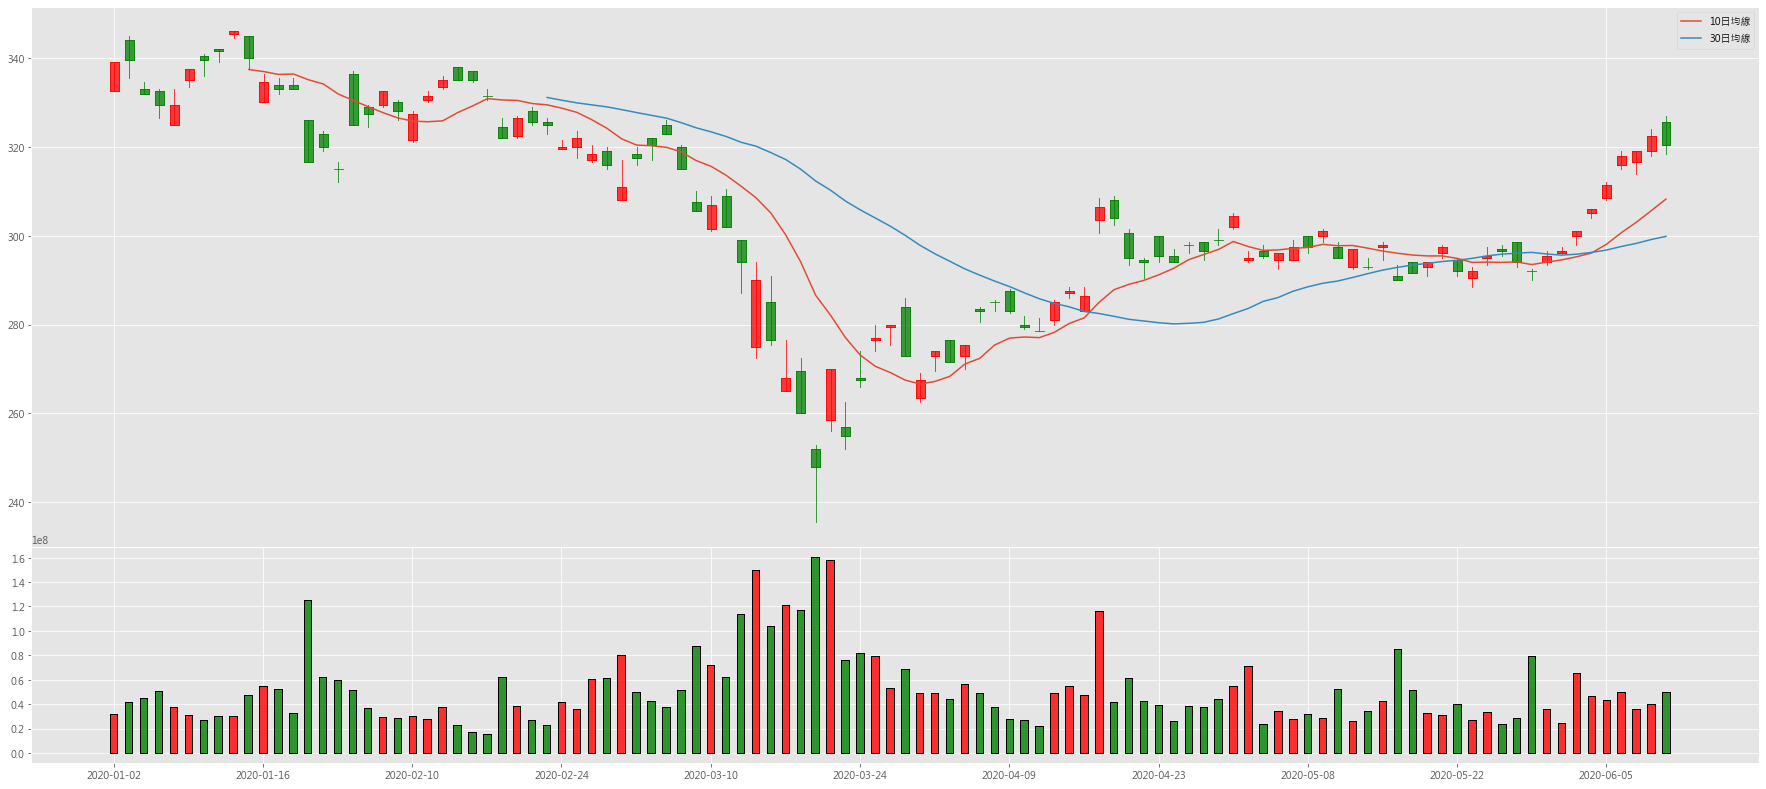

In [130]:

start = datetime.datetime(2020,1,1)
df_2330 = pdr.DataReader('2330.TW', 'yahoo', start=start)
df_2330.index = df_2330.index.format(formatter=lambda x: x.strftime('%Y-%m-%d')) 
#plt.style.use('ggplot')
fig = plt.figure(figsize=(24, 15))

#ax = fig.add_subplot(1, 1, 1)
ax = fig.add_axes([0,0.2,1,0.5])
ax2 = fig.add_axes([0,0,1,0.2])
ax.set_xticks(range(0, len(df_2330.index), 100))
ax.set_xticklabels(df_2330.index[::100])#10唯一循環
mpf.candlestick2_ochl(ax, df_2330['Open'], df_2330['Close'], df_2330['High'],
df_2330['Low'], width=0.6, colorup='r', colordown='g', alpha=0.75); 

sma_10 = talib.SMA(np.array(df_2330['Close']), 10)
sma_30 = talib.SMA(np.array(df_2330['Close']), 30)

plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(sma_10, label='10日均線')
ax.plot(sma_30, label='30日均線')

mpf.volume_overlay(ax2, df_2330['Open'], df_2330['Close'], df_2330['Volume'], colorup='r', colordown='g', width=0.5, alpha=0.8)
ax2.set_xticks(range(0, len(df_2330.index), 10))
ax2.set_xticklabels(df_2330.index[::10])
ax.legend();

             High    Low   Open  Close       Volume  Adj Close
Date                                                          
2018-01-02  12.45  12.35  12.40  12.35   36296346.0  10.377884
2018-01-03  12.55  12.40  12.40  12.45   40395182.0  10.461916
2018-01-04  12.70  12.50  12.55  12.50   75023561.0  10.503932
2018-01-05  12.55  12.40  12.55  12.50   38785738.0  10.503932
2018-01-08  12.65  12.50  12.60  12.60   36358963.0  10.587963
...           ...    ...    ...    ...          ...        ...
2020-06-01   7.85   7.64   7.70   7.77   53732373.0   7.770000
2020-06-02   7.98   7.80   7.92   7.83   66178821.0   7.830000
2020-06-03   8.61   8.01   8.06   8.61  319629141.0   8.610000
2020-06-04   8.83   8.44   8.81   8.49  216049237.0   8.490000
2020-06-05   9.07   8.50   8.51   8.97  202912739.0   8.970000

[587 rows x 6 columns]


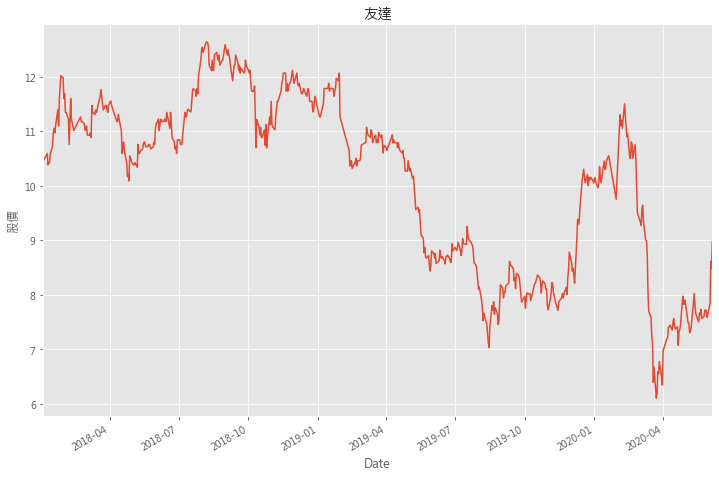

In [31]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties




import twstock
def df_test(number):
    plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    plt.style.use('ggplot')
    start = datetime.datetime(2018,1,1)
    global df_#回傳給test_forecast 預測方法用
    try:
        df_ = pdr.DataReader(number+'.TW','yahoo',start=start)
    except:
        return('NO')
    print(df_)
    plt.title(twstock.codes[number][2])
    #plt.style.use('ggplot')
    test = df_['Adj Close']
    #print(list(test))#該股  列表歷史收盤
    #test_vol = df_['Volume']

    #plt.title('我')
    plt.ylabel(u"股價")


    test.plot(figsize=(12,8))
    #test_vol.plot(figsize=(12,8))
    #print(test)
df_test('2409')

In [34]:
now = datetime.datetime.now()
now_date = datetime.datetime(now.year,now.month,now.day)
print(now_date)
try:
    df = pdr.DataReader('1234'+'.TW','yahoo',start=now_date)
    print(df)
except KeyError:
    pass
a =df['Close']
print(a)
print(list(a))
test = round(a[0],2)
print(type(test))


2020-06-07 00:00:00
Date
2020-06-05    32.900002
Name: Close, dtype: float64
[32.900001525878906]
<class 'numpy.float64'>


In [139]:
urllib3.disable_warnings()#解決 會跳出 request InsecureRequestWarning問題
header = {
        'User-Agent': userAgent
    }
r = requests.get('http://172.16.210.101'+'/domain_list',headers=header)
soup = BeautifulSoup(r.text,'lxml')

url_dict ={}#存放url 和 皆口狀態
try:# 過濾 從頁面上抓取的url, 有些沒帶http
    for i in soup.find_all('table',{'class':'domain_table'}):
        for a in i.find_all('a'):
            if 'http' not in a.text:
                url = 'http://'+a.text
                url_dict[url] = ''#先存訪到url_dict
            else:# 這邊提供的  頁面 不用做額外處理, 就是 a.text
                url_dict[a.text]=''
    threads = []
    for url_key in url_dict:
        threads.append(threading.Thread(target=session_get,args=(url_key,)))
    for i in threads:
        print(i)
        i.start()
    for i in threads:
        i.join()
except requests.Timeout as e:
    pass
print(url_dict)



<Thread(Thread-60, initial)>
<Thread(Thread-61, initial)>
<Thread(Thread-62, initial)>
<Thread(Thread-63, initial)>
<Thread(Thread-64, initial)>
<Thread(Thread-65, initial)>
<Thread(Thread-66, initial)>
<Thread(Thread-67, initial)>
<Thread(Thread-68, initial)>
<Thread(Thread-69, initial)>
<Thread(Thread-70, initial)>
<Thread(Thread-71, initial)>
<Thread(Thread-72, initial)>
<Thread(Thread-73, initial)>
<Thread(Thread-74, initial)>
<Thread(Thread-75, initial)>
<Thread(Thread-76, initial)>
<Thread(Thread-77, initial)>
<Thread(Thread-78, initial)>
<Thread(Thread-79, initial)>
<Thread(Thread-80, initial)>
<Thread(Thread-81, initial)>
<Thread(Thread-82, initial)>
<Thread(Thread-83, initial)>
<Thread(Thread-84, initial)>
<Thread(Thread-85, initial)>
<Thread(Thread-86, initial)>
{'https://www.yhz6288.com': 200, 'https://www.yhz6688.com': 200, 'https://www.yhz5678.com': 200, 'https://www.yhz7683.com': 200, 'https://www.ehz119.com': 200, 'https://www.yhz0000.com': 200, 'https://www.2hz01.com': 

'\nfor url in url_list:\n    try:\n        r = requests.get(url+\'/\',headers=header,verify=False,timeout=5)#https 不認證,否則會跳ssl error\n    except requests.Timeout as e:\n        pass\n        #print(e)\n    if r.encoding == \'ISO-8859-1\':# 確認編碼狀態,  iso-8859-1 的 title 會亂碼\n        html = BeautifulSoup(r.text.encode(\'ISO-8859-1\').decode(\'utf-8\'),\'lxml\')\n    else:\n        html = BeautifulSoup(r.text,\'lxml\')\n    print("%s: 接口狀態: %s,%s"%(url,r.status_code,html.title))\n'

In [12]:
def admin_Login(url):
    global admin_cookie
    global admin_url
    global envs
    global userAgent
    global session
    global header
    admin_cookie = {} 
    session = requests.Session()
    
    header = {
        'User-Agent': userAgent,
        'Content-Type':'application/x-www-form-urlencoded; charset=UTF-8'
    }

    admin_url = 'http://admin.%s.com'%url
    username = 'cancus'
    bindpwd = 123456
    if url in ['dev02','dev03']:
        password = '123qwe'
        envs = 0
    elif url == 'joy188':
        password = 'amberrd'
        envs = 1
    else:#生產  phl58'
        username = 'tprd'
        password = 'amberrd'
        r = session.get('http://admin.dev03.com'+'/admin/login/bindpwd',headers=header)
        bindpwd = (r.text.split('<br>')[2])
        envs = 2

    data_ = {
        'username':username,
        'password':password,
        'bindpwd':bindpwd 
    }
    
    # 'username=cancus&password=123qwe&bindpwd=123456'
    r = session.post(admin_url+'/admin/login/login',data = data_, headers = header)
    global cookies
    cookies = r.cookies.get_dict()#獲得登入的cookies 字典
    
    admin_cookie['admin_cookie'] =  cookies['ANVOAID']
    t = time.strftime('%Y%m%d %H:%M:%S')
    print('登錄環境%s,'%url+'現在時間:'+t)
    print(r.text)
    
    
admin_Login('dev02')

登錄環境dev02,現在時間:20200603 20:03:48
﻿{"isSuccess":1}


In [809]:

def add_activity(num,user):# 增加後台禮金
    header={
            'User-Agent': userAgent,
            'Cookie': 'ANVOAID='+cookies['ANVOAID'],
             'Accept':'application/json, text/javascript, */*; q=0.01',
            'Content-Type':'application/x-www-form-urlencoded; charset=UTF-8'
         } 
    data = "rcvAct=%s&depositAmt=10&memo=test&id=&userId=1341294&sSelectValue=3&note=test& \
    chargeSn="%user
    while True:
        try:
            r = session.post(admin_url+'/admin/Opterators/index?parma=opter1',headers=header,data=data)
    # 後台加活動今
            if (r.json()['status']) == 'ok':
                print('%s後台建立成功'%user)
            else:
                print('建立失敗')
            times = num+1
            print('值型第%s次'%times)
            if times%100 == 0:
                select_fundID(get_conn(0))
                for i in fund_id:
                    data = 'id=%s&status=1&typeId=3'%i
                    r =session.post(admin_url+'/admin/Opterators/index?parma=sv2',headers=header,data=data)
                    if r.json()['status'] == 'ok':
                        print('加活動禮金成功')
                    else:
                        print('失敗')
            else:
                pass
            break
        except UnicodeEncodeError as e:
            print(e)
            break
        
def activity_confirm():# 審核,需透過DB 查id
    select_fundID(get_conn(0))
    for i in fund_id:
        data = 'id=%s&status=1&typeId=3'%i
        r =session.post(admin_url+'/admin/Opterators/index?parma=sv2',headers=header,data=data)
        if r.json()['status'] == 'ok':
            print('加活動禮金成功')
        else:
            print('失敗')

In [810]:
r =session.get(admin_url+'/admin/Opterators/index?parma=sv1',headers=header)
soup =  BeautifulSoup(r.text,'lxml')
print(soup)
a = soup.find_all('tbody',{'id':'showInfo2'})
for i in a:
    print(i.text)

NameError: name 'session' is not defined

In [96]:
def tran_user(move_type): # 代理線轉移
    header['ANVOAID'] = cookies['ANVOAID']
    if move_type ==0:#提升總代
        move_type = 'ga'
        target = ''# 提升總代 無需目標
        select_tranUser(get_conn(1),'%kerr%',1)#抓出一代用戶
        user = tran_user[0]
        print('用戶: %s轉移至總代'%user)
    elif move_type ==1:#跨代理轉一代
        move_type = 'loa'
        select_tranUser(get_conn(1),'%kerr%',2)#抓出二代用戶,目標需為不同上級
        random_user = random.randint(1,len(tran_user))# 隨機取出用戶,避免容易失敗,
        user = tran_user[random_user]#要做的用戶
        #print(user)
        target = user_chain[0].split('/')[1]# 此為  抓出來的總帶,  需找出  不是這個總帶的一帶
        #print(target)
        select_tranChainUser(get_conn(1),target,'%kerr%')# 抓出 不同的總帶
        random_user = random.randint(1,len(tran_user))# 隨機取出總代,避免容易失敗,
        target = tran_user[random_user]#此用戶 即為  目標
        #print(target)
        print('二代: %s用戶,轉移至一代,新總代為: %s'%(user,target))
    elif move_type == 2:#相同代理,跨上去一層
        move_type = 'lua'
        select_tranUser(get_conn(1),'%kerr%',3)#抓出三代用戶,目標需為相同上級
        user = tran_user[0]#要做的用戶
        target = user_chain[0].split('/')[1]# 此為  抓出來的總帶,  需找出  是這個用戶的總代
        print('三代: %s用戶,轉移至二代,相同總代為: %s'%(user,target))
        
    data = 'moveAccount=%s&targetAccount=%s&moveType=%s'%(user,target,move_type)# 要做轉移的用戶,目標用戶 ,類型 
    r= session.post(admin_url+'/admin/user/userchaincreate',headers=header,data=data)
    #print(r.json())
    if 'true' in r.text:
        print('成功')
    else:
        print(r.json()['errorMsg'])
    
    
#tran_user(move_type=2)

In [ ]:
any(s in domain for s in ['joy188','dev'])

In [201]:
def kerr_conn():
    db = p.connect(
    host="127.0.0.1",
    user="root",
    passwd="password",
    database="STOCK_TEST",
    use_unicode=True,
    charset="utf8"
    )
    return db
def kerr_insert(db,list_name,type_): # list_name  為一個列表裡面  ,是tuple 的值
    cur = db.cursor()
    if type_ ==1 : #每月營收
    # insert  所有表
        sql = "INSERT INTO STOCK_REV  \
        (ID ,STOCK_NUM ,STOCK_NAME ,STOCK_CUR_MONREV ,STOCK_LAST_MONREV ,\
        STOCK_LAST_YEARMONREV,STOCK_LAST_MONRATE ,STOCK_LAST_YEARMONRATE,STOCK_CUR_YEARREV ,\
        STOCK_LAST_YEARREV ,STOCK_YEARRATE  ,STOCK_MEMO) Values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s, %s,%s)"
    elif type_ ==2:
        sql = "INSERT INTO STOCK_GOV \
        (STOCK_NUM,GOV_SELL,CUR_DATE) Values (%s,%s,%s)"
    else:# 給別的想inset處理的條件
        sql = "INSERT INTO STOCK_GOV (CUR_DATE) Values(%s)" 
    cur.executemany(sql,list_name)
    db.commit()
    print("insert成功")
    cur.close()
def kerr_update2(db):# 找出對應號碼, update 營收
    cur = db.cursor()
    for num in range(len(stock_Name)):
        
        sql = "UPDATE STOCK_REV SET STOCK_CUR_MONREV = %s,STOCK_LAST_MONREV=%s,STOCK_LAST_YEARMONREV=%s, \
        STOCK_LAST_MONRATE=%s ,STOCK_LAST_YEARMONRATE=%s,STOCK_CUR_YEARREV=%s ,STOCK_LAST_YEARREV=%s ,\
        STOCK_YEARRATE=%s  ,STOCK_MEMO ='%s'  \
        WHERE STOCK_NUM = %s"%(stock_Name[num][3],stock_Name[num][4],stock_Name[num][5],stock_Name[num][6],
        stock_Name[num][7],stock_Name[num][8],stock_Name[num][9],stock_Name[num][10],stock_Name[num][11],
        stock_Name[num][1])
        print('%s update營收完成'%num)
        cur.execute(sql)
        
    db.commit()
    print("update完成")
    cur.close()
def kerr_select(db):#找出股號, 然後傳到 twstock, 找出股價
    cur = db.cursor()
    sql = "SELECT STOCK_NUM from STOCK_REV"
    cur.execute(sql)
    global stock_num
    stock_num = []
    rows = cur.fetchall()
    for i in rows:
        stock_num.append(i[0])
    cur.close()


In [178]:
kerr_select(kerr_conn())# 
print(len(stock_num))

867


In [106]:
stock_Name

[(0,
  1101,
  '台泥',
  9961312,
  10285516,
  9866871,
  -3.15,
  0.95,
  52439710,
  56723483,
  -7.55,
  '-'),
 (1,
  1102,
  '亞泥',
  6752208,
  7182969,
  7536507,
  -5.99,
  -10.4,
  33825643,
  43797688,
  -22.76,
  '-'),
 (2,
  1103,
  '嘉泥',
  166768,
  171405,
  130823,
  -2.7,
  27.47,
  992319,
  890444,
  11.44,
  '-'),
 (3,
  1104,
  '環泥',
  453562,
  403105,
  353927,
  12.51,
  28.15,
  2591631,
  2381467,
  8.82,
  '-'),
 (4,
  1108,
  '幸福',
  360616,
  357162,
  271998,
  0.96,
  32.58,
  2226696,
  1735453,
  28.3,
  '-'),
 (5,
  1109,
  '信大',
  611254,
  706916,
  658066,
  -13.53,
  -7.11,
  3255948,
  3572169,
  -8.85,
  '-'),
 (6,
  1110,
  '東泥',
  130369,
  106356,
  114080,
  22.57,
  14.27,
  770491,
  781597,
  -1.42,
  '-'),
 (8,
  1201,
  '味全',
  1584018,
  1557936,
  1728231,
  1.67,
  -8.34,
  8589703,
  9774563,
  -12.12,
  '-'),
 (9,
  1203,
  '味王',
  519138,
  467509,
  574920,
  11.04,
  -9.7,
  3051105,
  3077619,
  -0.86,
  '-'),
 (10,
  1210,
  '大成',


In [135]:
kerr_update2(kerr_conn())#塞每月營收資料 進表

0 update營收完成


KeyboardInterrupt: 

In [609]:
kerr_insert(kerr_conn(),stock_test[list(stock_test.keys())[0]],2)#更新每日法人買

insert成功


In [203]:
kerr_update2(kerr_conn())

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 10216799,STOCK_LAST_MONREV=9473250,STOCK_LAST_YEARMONREV=10596314,         STOCK_LAST_MONRATE=7.84 ,STOCK_LAST_YEARMONRATE=-3.58,STOCK_CUR_YEARREV=32192882 ,STOCK_LAST_YEARREV=35952645 ,        STOCK_YEARRATE=-10.45  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1101
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 6751585,STOCK_LAST_MONREV=5077457,STOCK_LAST_YEARMONREV=8434811,         STOCK_LAST_MONRATE=32.97 ,STOCK_LAST_YEARMONRATE=-19.95,STOCK_CUR_YEARREV=19890466 ,STOCK_LAST_YEARREV=27825416 ,        STOCK_YEARRATE=-28.51  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1102
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 481205,STOCK_LAST_MONREV=479717,STOCK_LAST_YEARMONREV=418992,         STOCK_LAST_MONRATE=0.31 ,STOCK_LAST_YEARMONRATE=14.84,STOCK_CUR_YEARREV=1734963 ,STOCK_LAST_YEARREV=1606289 ,        STOCK_YEARRATE=8.01  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1104
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 404198,STOCK_LAST_MONREV=418037,STOCK_LAST_YEAR

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 97050,STOCK_LAST_MONREV=172867,STOCK_LAST_YEARMONREV=131729,         STOCK_LAST_MONRATE=-43.85 ,STOCK_LAST_YEARMONRATE=-26.32,STOCK_CUR_YEARREV=576195 ,STOCK_LAST_YEARREV=508958 ,        STOCK_YEARRATE=13.21  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1441
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 40630,STOCK_LAST_MONREV=55681,STOCK_LAST_YEARMONREV=63051,         STOCK_LAST_MONRATE=-27.03 ,STOCK_LAST_YEARMONRATE=-35.56,STOCK_CUR_YEARREV=186257 ,STOCK_LAST_YEARREV=240390 ,        STOCK_YEARRATE=-22.51  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1443
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 613571,STOCK_LAST_MONREV=888025,STOCK_LAST_YEARMONREV=1020252,         STOCK_LAST_MONRATE=-30.9 ,STOCK_LAST_YEARMONRATE=-39.86,STOCK_CUR_YEARREV=3057270 ,STOCK_LAST_YEARREV=4207330 ,        STOCK_YEARRATE=-27.33  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1444
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 53183,STOCK_LAST_MONREV=101807,STOCK_LAST_YEARMONREV=124374

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 156566,STOCK_LAST_MONREV=212014,STOCK_LAST_YEARMONREV=282191,         STOCK_LAST_MONRATE=-26.15 ,STOCK_LAST_YEARMONRATE=-44.51,STOCK_CUR_YEARREV=812712 ,STOCK_LAST_YEARREV=735822 ,        STOCK_YEARRATE=10.44  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1603
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 577889,STOCK_LAST_MONREV=573093,STOCK_LAST_YEARMONREV=672274,         STOCK_LAST_MONRATE=0.83 ,STOCK_LAST_YEARMONRATE=-14.03,STOCK_CUR_YEARREV=2386110 ,STOCK_LAST_YEARREV=2439352 ,        STOCK_YEARRATE=-2.18  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1604
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 12913956,STOCK_LAST_MONREV=9160981,STOCK_LAST_YEARMONREV=14156462,         STOCK_LAST_MONRATE=40.96 ,STOCK_LAST_YEARMONRATE=-8.77,STOCK_CUR_YEARREV=37109155 ,STOCK_LAST_YEARREV=51209199 ,        STOCK_YEARRATE=-27.53  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1605
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 500631,STOCK_LAST_MONREV=674058,STOCK_LAST_YEARMONR

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 701073,STOCK_LAST_MONREV=728371,STOCK_LAST_YEARMONREV=668917,         STOCK_LAST_MONRATE=-3.74 ,STOCK_LAST_YEARMONRATE=4.8,STOCK_CUR_YEARREV=2806750 ,STOCK_LAST_YEARREV=2663104 ,        STOCK_YEARRATE=5.39  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1701
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 370344,STOCK_LAST_MONREV=393137,STOCK_LAST_YEARMONREV=321953,         STOCK_LAST_MONRATE=-5.79 ,STOCK_LAST_YEARMONRATE=15.03,STOCK_CUR_YEARREV=1404753 ,STOCK_LAST_YEARREV=1168129 ,        STOCK_YEARRATE=20.25  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 1720
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 130885,STOCK_LAST_MONREV=169925,STOCK_LAST_YEARMONREV=193298,         STOCK_LAST_MONRATE=-22.97 ,STOCK_LAST_YEARMONRATE=-32.28,STOCK_CUR_YEARREV=642815 ,STOCK_LAST_YEARREV=718232 ,        STOCK_YEARRATE=-10.5  ,STOCK_MEMO ='因COVID-19造成原物料短缺及航運減班， 以致遞延岀貨。'          WHERE STOCK_NUM = 1733
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 1663022,STOCK_LAST_MONREV=2274687

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 429089,STOCK_LAST_MONREV=507801,STOCK_LAST_YEARMONREV=544030,         STOCK_LAST_MONRATE=-15.5 ,STOCK_LAST_YEARMONRATE=-21.12,STOCK_CUR_YEARREV=1925582 ,STOCK_LAST_YEARREV=2415245 ,        STOCK_YEARRATE=-20.27  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2007
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 60529,STOCK_LAST_MONREV=65493,STOCK_LAST_YEARMONREV=104792,         STOCK_LAST_MONRATE=-7.57 ,STOCK_LAST_YEARMONRATE=-42.23,STOCK_CUR_YEARREV=271661 ,STOCK_LAST_YEARREV=525422 ,        STOCK_YEARRATE=-48.29  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2008
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 187792,STOCK_LAST_MONREV=226830,STOCK_LAST_YEARMONREV=196095,         STOCK_LAST_MONRATE=-17.21 ,STOCK_LAST_YEARMONRATE=-4.23,STOCK_CUR_YEARREV=744305 ,STOCK_LAST_YEARREV=788986 ,        STOCK_YEARRATE=-5.66  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2009
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 1535784,STOCK_LAST_MONREV=1570746,STOCK_LAST_YEARMONREV=1315

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 353752,STOCK_LAST_MONREV=337465,STOCK_LAST_YEARMONREV=335460,         STOCK_LAST_MONRATE=4.82 ,STOCK_LAST_YEARMONRATE=5.45,STOCK_CUR_YEARREV=1356864 ,STOCK_LAST_YEARREV=1349620 ,        STOCK_YEARRATE=0.53  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3016
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 6544234,STOCK_LAST_MONREV=5811922,STOCK_LAST_YEARMONREV=5520124,         STOCK_LAST_MONRATE=12.6 ,STOCK_LAST_YEARMONRATE=18.55,STOCK_CUR_YEARREV=23435388 ,STOCK_LAST_YEARREV=20466560 ,        STOCK_YEARRATE=14.5  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3034
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 366924,STOCK_LAST_MONREV=444727,STOCK_LAST_YEARMONREV=354076,         STOCK_LAST_MONRATE=-17.49 ,STOCK_LAST_YEARMONRATE=3.62,STOCK_CUR_YEARREV=1632348 ,STOCK_LAST_YEARREV=1451455 ,        STOCK_YEARRATE=12.46  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3035
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 139187,STOCK_LAST_MONREV=160331,STOCK_LAST_YEARMONREV=12637

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 94304826,STOCK_LAST_MONREV=80770843,STOCK_LAST_YEARMONREV=81821066,         STOCK_LAST_MONRATE=16.75 ,STOCK_LAST_YEARMONRATE=15.25,STOCK_CUR_YEARREV=276352091 ,STOCK_LAST_YEARREV=292420500 ,        STOCK_YEARRATE=-5.49  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2324
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 2679634,STOCK_LAST_MONREV=1702273,STOCK_LAST_YEARMONREV=2534665,         STOCK_LAST_MONRATE=57.41 ,STOCK_LAST_YEARMONRATE=5.71,STOCK_CUR_YEARREV=6794196 ,STOCK_LAST_YEARREV=8845329 ,        STOCK_YEARRATE=-23.18  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2331
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 14487094,STOCK_LAST_MONREV=14595548,STOCK_LAST_YEARMONREV=12901390,         STOCK_LAST_MONRATE=-0.74 ,STOCK_LAST_YEARMONRATE=12.29,STOCK_CUR_YEARREV=53687261 ,STOCK_LAST_YEARREV=52755114 ,        STOCK_YEARRATE=1.76  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2352
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 19747695,STOCK_LAST_MONREV=24070662,STO

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 42092,STOCK_LAST_MONREV=35577,STOCK_LAST_YEARMONREV=48238,         STOCK_LAST_MONRATE=18.31 ,STOCK_LAST_YEARMONRATE=-12.74,STOCK_CUR_YEARREV=124261 ,STOCK_LAST_YEARREV=195513 ,        STOCK_YEARRATE=-36.44  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 6172
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 312149,STOCK_LAST_MONREV=410776,STOCK_LAST_YEARMONREV=469629,         STOCK_LAST_MONRATE=-24.0 ,STOCK_LAST_YEARMONRATE=-33.53,STOCK_CUR_YEARREV=1569139 ,STOCK_LAST_YEARREV=1903618 ,        STOCK_YEARRATE=-17.57  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 6206
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 127037,STOCK_LAST_MONREV=162549,STOCK_LAST_YEARMONREV=170050,         STOCK_LAST_MONRATE=-21.84 ,STOCK_LAST_YEARMONRATE=-25.29,STOCK_CUR_YEARREV=576809 ,STOCK_LAST_YEARREV=939483 ,        STOCK_YEARRATE=-38.6  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 6235
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 362109,STOCK_LAST_MONREV=395293,STOCK_LAST_YEARMONREV=389662

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 37995,STOCK_LAST_MONREV=31844,STOCK_LAST_YEARMONREV=41924,         STOCK_LAST_MONRATE=19.31 ,STOCK_LAST_YEARMONRATE=-9.37,STOCK_CUR_YEARREV=154560 ,STOCK_LAST_YEARREV=180122 ,        STOCK_YEARRATE=-14.19  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3622
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 210877,STOCK_LAST_MONREV=203810,STOCK_LAST_YEARMONREV=177863,         STOCK_LAST_MONRATE=3.46 ,STOCK_LAST_YEARMONRATE=18.56,STOCK_CUR_YEARREV=684987 ,STOCK_LAST_YEARREV=642266 ,        STOCK_YEARRATE=6.65  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3669
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 754604,STOCK_LAST_MONREV=623222,STOCK_LAST_YEARMONREV=815899,         STOCK_LAST_MONRATE=21.08 ,STOCK_LAST_YEARMONRATE=-7.51,STOCK_CUR_YEARREV=2433403 ,STOCK_LAST_YEARREV=2983505 ,        STOCK_YEARRATE=-18.43  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3698
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 188914,STOCK_LAST_MONREV=165322,STOCK_LAST_YEARMONREV=179959,     

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 818836,STOCK_LAST_MONREV=1251335,STOCK_LAST_YEARMONREV=1282075,         STOCK_LAST_MONRATE=-34.56 ,STOCK_LAST_YEARMONRATE=-36.13,STOCK_CUR_YEARREV=4490368 ,STOCK_LAST_YEARREV=5483064 ,        STOCK_YEARRATE=-18.1  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2332
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 4071989,STOCK_LAST_MONREV=4651577,STOCK_LAST_YEARMONREV=4533144,         STOCK_LAST_MONRATE=-12.46 ,STOCK_LAST_YEARMONRATE=-10.17,STOCK_CUR_YEARREV=15796241 ,STOCK_LAST_YEARREV=15701700 ,        STOCK_YEARRATE=0.6  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2345
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 567011,STOCK_LAST_MONREV=645678,STOCK_LAST_YEARMONREV=954030,         STOCK_LAST_MONRATE=-12.18 ,STOCK_LAST_YEARMONRATE=-40.56,STOCK_CUR_YEARREV=2014536 ,STOCK_LAST_YEARREV=3540359 ,        STOCK_YEARRATE=-43.09  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2419
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 2068643,STOCK_LAST_MONREV=2627338,STOCK_LAST_YE

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 683639,STOCK_LAST_MONREV=689817,STOCK_LAST_YEARMONREV=625069,         STOCK_LAST_MONRATE=-0.89 ,STOCK_LAST_YEARMONRATE=9.37,STOCK_CUR_YEARREV=2251286 ,STOCK_LAST_YEARREV=2266241 ,        STOCK_YEARRATE=-0.65  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2472
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 421577,STOCK_LAST_MONREV=396120,STOCK_LAST_YEARMONREV=412622,         STOCK_LAST_MONRATE=6.42 ,STOCK_LAST_YEARMONRATE=2.17,STOCK_CUR_YEARREV=1457428 ,STOCK_LAST_YEARREV=1635805 ,        STOCK_YEARRATE=-10.9  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2476
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 481418,STOCK_LAST_MONREV=493656,STOCK_LAST_YEARMONREV=371632,         STOCK_LAST_MONRATE=-2.47 ,STOCK_LAST_YEARMONRATE=29.54,STOCK_CUR_YEARREV=1570100 ,STOCK_LAST_YEARREV=1420533 ,        STOCK_YEARRATE=10.52  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2478
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 168236,STOCK_LAST_MONREV=157548,STOCK_LAST_YEARMONREV=151044, 

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 1441172,STOCK_LAST_MONREV=1103128,STOCK_LAST_YEARMONREV=1432565,         STOCK_LAST_MONRATE=30.64 ,STOCK_LAST_YEARMONRATE=0.6,STOCK_CUR_YEARREV=4128019 ,STOCK_LAST_YEARREV=5052329 ,        STOCK_YEARRATE=-18.29  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 6153
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 52298,STOCK_LAST_MONREV=52082,STOCK_LAST_YEARMONREV=48768,         STOCK_LAST_MONRATE=0.41 ,STOCK_LAST_YEARMONRATE=7.23,STOCK_CUR_YEARREV=187084 ,STOCK_LAST_YEARREV=185105 ,        STOCK_YEARRATE=1.06  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 6155
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 63,STOCK_LAST_MONREV=352,STOCK_LAST_YEARMONREV=153,         STOCK_LAST_MONRATE=-82.1 ,STOCK_LAST_YEARMONRATE=-58.82,STOCK_CUR_YEARREV=599 ,STOCK_LAST_YEARREV=1000 ,        STOCK_YEARRATE=-40.1  ,STOCK_MEMO ='受大陸低價競爭之影響，公司營收較去年同期衰退。'          WHERE STOCK_NUM = 6165
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 1840513,STOCK_LAST_MONREV=1825019,STOCK_LAST_YEARMONREV=181

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 727407,STOCK_LAST_MONREV=909921,STOCK_LAST_YEARMONREV=734396,         STOCK_LAST_MONRATE=-20.05 ,STOCK_LAST_YEARMONRATE=-0.95,STOCK_CUR_YEARREV=3259216 ,STOCK_LAST_YEARREV=2831769 ,        STOCK_YEARRATE=15.09  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 3029
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 255388,STOCK_LAST_MONREV=216519,STOCK_LAST_YEARMONREV=223779,         STOCK_LAST_MONRATE=17.95 ,STOCK_LAST_YEARMONRATE=14.12,STOCK_CUR_YEARREV=1027779 ,STOCK_LAST_YEARREV=1039529 ,        STOCK_YEARRATE=-1.13  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 4994
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 146737,STOCK_LAST_MONREV=112152,STOCK_LAST_YEARMONREV=126150,         STOCK_LAST_MONRATE=30.83 ,STOCK_LAST_YEARMONRATE=16.31,STOCK_CUR_YEARREV=503491 ,STOCK_LAST_YEARREV=453483 ,        STOCK_YEARRATE=11.02  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 5203
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 1197807,STOCK_LAST_MONREV=1107034,STOCK_LAST_YEARMONREV=1047

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 193645,STOCK_LAST_MONREV=220416,STOCK_LAST_YEARMONREV=356418,         STOCK_LAST_MONRATE=-12.14 ,STOCK_LAST_YEARMONRATE=-45.66,STOCK_CUR_YEARREV=824696 ,STOCK_LAST_YEARREV=996554 ,        STOCK_YEARRATE=-17.24  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2527
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 21,STOCK_LAST_MONREV=21,STOCK_LAST_YEARMONREV=3096,         STOCK_LAST_MONRATE=0.0 ,STOCK_LAST_YEARMONRATE=-99.32,STOCK_CUR_YEARREV=84 ,STOCK_LAST_YEARREV=5823 ,        STOCK_YEARRATE=-98.55  ,STOCK_MEMO ='主係109年04月認列租賃收入21仟元所致'          WHERE STOCK_NUM = 2528
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 655,STOCK_LAST_MONREV=701,STOCK_LAST_YEARMONREV=706,         STOCK_LAST_MONRATE=-6.56 ,STOCK_LAST_YEARMONRATE=-7.22,STOCK_CUR_YEARREV=2872 ,STOCK_LAST_YEARREV=4633 ,        STOCK_YEARRATE=-38.0  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2530
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 144191,STOCK_LAST_MONREV=228860,STOCK_LAST_YEARMONREV=145572,         S

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 3971006,STOCK_LAST_MONREV=2393636,STOCK_LAST_YEARMONREV=3517536,         STOCK_LAST_MONRATE=65.89 ,STOCK_LAST_YEARMONRATE=12.89,STOCK_CUR_YEARREV=13944600 ,STOCK_LAST_YEARREV=14593809 ,        STOCK_YEARRATE=-4.44  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2887
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 19827418,STOCK_LAST_MONREV=15653326,STOCK_LAST_YEARMONREV=22580675,         STOCK_LAST_MONRATE=26.66 ,STOCK_LAST_YEARMONRATE=-12.19,STOCK_CUR_YEARREV=88994374 ,STOCK_LAST_YEARREV=90545057 ,        STOCK_YEARRATE=-1.71  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 2888
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 749345,STOCK_LAST_MONREV=489221,STOCK_LAST_YEARMONREV=476438,         STOCK_LAST_MONRATE=53.17 ,STOCK_LAST_YEARMONRATE=57.28,STOCK_CUR_YEARREV=2245048 ,STOCK_LAST_YEARREV=2109510 ,        STOCK_YEARRATE=6.42  ,STOCK_MEMO ='本月透過損益按公允價值衡量之金融資產及負債損益較去年+206658仟元'          WHERE STOCK_NUM = 2889
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 3296553,STOC

UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 203236,STOCK_LAST_MONREV=240346,STOCK_LAST_YEARMONREV=173006,         STOCK_LAST_MONRATE=-15.44 ,STOCK_LAST_YEARMONRATE=17.47,STOCK_CUR_YEARREV=869750 ,STOCK_LAST_YEARREV=715675 ,        STOCK_YEARRATE=21.52  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 8341
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 201092,STOCK_LAST_MONREV=254512,STOCK_LAST_YEARMONREV=240340,         STOCK_LAST_MONRATE=-20.98 ,STOCK_LAST_YEARMONRATE=-16.33,STOCK_CUR_YEARREV=853187 ,STOCK_LAST_YEARREV=920774 ,        STOCK_YEARRATE=-7.34  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 8422
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 1698992,STOCK_LAST_MONREV=1571832,STOCK_LAST_YEARMONREV=1989071,         STOCK_LAST_MONRATE=8.08 ,STOCK_LAST_YEARMONRATE=-14.58,STOCK_CUR_YEARREV=6354677 ,STOCK_LAST_YEARREV=7166741 ,        STOCK_YEARRATE=-11.33  ,STOCK_MEMO ='-'          WHERE STOCK_NUM = 8464
UPDATE STOCK_TEST SET STOCK_CUR_MONREV = 314448,STOCK_LAST_MONREV=419813,STOCK_LAST_YEARMONREV=38

In [121]:
def soup_stock():# 抓取數據 , len_index  為抓到的東西 , date 為時間 ,格式 109_3 ,每月營收數據
    userAgent ="Mozilla/5.0 (Windows NT 10.0; Win64; x64)\
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36"
    urllib3.disable_warnings()#解決 會跳出 request InsecureRequestWarning問題
    header = {
            'User-Agent': userAgent,
            'Content-Type':'application/x-www-form-urlencoded; charset=UTF-8'
        }
    session = requests.Session()
    now = datetime.datetime.now()#年找出今年.  月和日做參數化.因為可能會找先前日棋
    year = now.year -1911# 換算民國
    month = now.month -1#抓上個月
    print("抓取%s月"%month)# 當月
    r = session.get('https://mops.twse.com.tw'+'/nas/t21/sii/t21sc03_%s_%s_0.html'
    %(year,month),headers=header,verify=False)
    r.encoding = 'Big5' #繁體編碼
    soup = BeautifulSoup(r.text,'lxml')
    #soup.encode('gb18030')
    #global len_index
    len_index = [i for i in soup.find_all('tr',{'align':'right'})]
    #print(len(len_index))
    global stock_Name
    stock_Name = [] #存放所有抓到的資訊
    stock_list =[]
    for number in range(len(len_index)-1):#先取出多少長度, -1 用意, 最後一行不是抓股資訊
        stock_list.append(number)# mysql 的 ID 欄位
        for text in len_index[number]:#再從len_index陣列,取出 每個index的資訊
            stock_list.append('0' if text.text.strip() in ['','合計']#strip()把空白部分去除
            else text.text.strip().replace(',',''))
        if stock_list[-1] == '0':#過濾 不是股票名稱的 
            pass
        else:
            for num,text in enumerate(stock_list):# 需判斷 各 欄位 型態, 因為要Inser進去 Mysql, 型態需和mysql 欄位一致
                if num in [0,1]:
                    text = int(text)
                elif num in [2,11]:
                    text = str(text)
                elif num in [6,7,10]:
                    text = float(text)
                else:
                    text = int(text)
                stock_list[num] = text
        if len(stock_list) != 12:# 這邊代表 抓到的 不是股名 那行,可能是 合計
            pass
        else:
            stock_Name.append(tuple(stock_list))# 轉成tuple用意 ,好insert資料進mysql
        stock_list= []
    print(len(stock_Name))

In [122]:
soup_stock()
stock_Name

抓取6月
866


[(0,
  1101,
  '台泥',
  9961312,
  10285516,
  9866871,
  -3.15,
  0.95,
  52439710,
  56723483,
  -7.55,
  '-'),
 (1,
  1102,
  '亞泥',
  6752208,
  7182969,
  7536507,
  -5.99,
  -10.4,
  33825643,
  43797688,
  -22.76,
  '-'),
 (2,
  1103,
  '嘉泥',
  166768,
  171405,
  130823,
  -2.7,
  27.47,
  992319,
  890444,
  11.44,
  '-'),
 (3,
  1104,
  '環泥',
  453562,
  403105,
  353927,
  12.51,
  28.15,
  2591631,
  2381467,
  8.82,
  '-'),
 (4,
  1108,
  '幸福',
  360616,
  357162,
  271998,
  0.96,
  32.58,
  2226696,
  1735453,
  28.3,
  '-'),
 (5,
  1109,
  '信大',
  611254,
  706916,
  658066,
  -13.53,
  -7.11,
  3255948,
  3572169,
  -8.85,
  '-'),
 (6,
  1110,
  '東泥',
  130369,
  106356,
  114080,
  22.57,
  14.27,
  770491,
  781597,
  -1.42,
  '-'),
 (8,
  1201,
  '味全',
  1584018,
  1557936,
  1728231,
  1.67,
  -8.34,
  8589703,
  9774563,
  -12.12,
  '-'),
 (9,
  1203,
  '味王',
  519138,
  467509,
  574920,
  11.04,
  -9.7,
  3051105,
  3077619,
  -0.86,
  '-'),
 (10,
  1210,
  '大成',


In [20]:


def my_con(evn,third):
    third_dict = {'lc':['lcadmin',['cA28yF#K=yx*RPHC','XyH]#xk76xY6e+bV'],'ff_lc'],
        'ky':['kyadmin',['ALtfN#F7Zj%AxXgs=dT9','kdT4W3#dEug3$pMM#z7q'],'ff_ky'],
        'city':['761cityadmin',['KDpTqUeRH7s-s#D*7]mY','bE%ytPX$5nU3c9#d'],'ff_761city'],
        'im':['imadmin',['D97W#$gdh=b39jZ7Px','nxDe2yt7XyuZ@CcNSE'],'ff_im'],
        'sb':['sbadmin',['UHRkbvu[2%N=5U*#P3JR','aR8(W294XV5KQ!Zf#"v9'],'ff_sb'],
        'bbin':['bbinadmin','Csyh*P#jB3y}EyLxtg','ff_bbin'],
        'gns':['gnsadmin','Gryd#aCPWCkT$F4pmn','ff_gns']
         }  
    if evn == 0:#dev
        ip = '10.13.22.151'
    elif evn == 1:#188
        ip = '10.6.32.147'
    else:
        print('evn 錯誤')
    
    user_ =  third_dict[third][0]
    db_ = third_dict[third][2]
    
    if third == 'gns':#gns只有一個 測試環境
        passwd_ = third_dict[third][1]
    else:
        passwd_ = third_dict[third][1][evn] 
    
    db = p.connect(
    host = ip,
    user = user_,
    passwd = passwd_,
    db = db_)
    return db
def mysql_avail(db,user):#第三方餘額

    cur = db.cursor()
    cur.execute("select avail_bal from THIRDLY_USER_CUSTOMER where ff_account = '%s'"%user)
    for row in cur.fetchall():
        return (row[0])
    cur.close()
    
def thirdly_tran(db,tran_type,third):#查詢第三方 單號 狀態
    cur = db.cursor()
    if third in ['lc','ky','city','im','sb']:
        table_name = 'THIRDLY_TRANSCATION_LOG'
        if tran_type == 0:
            trans_name = 'FIREFROG_TO_THIRDLY'
        else:
            trans_name = 'THIRDLY_TO_FIREFROG'
    elif third  == 'gns':
        table_name = 'GNS_TRANSCATION_LOG'
        if tran_type == 0:
            trans_name = 'FIREFROG_TO_GNS'
        else:
            trans_name = 'GNS_TO_FIREFROG'
    else:
        print('第三方 名稱錯誤')

    sql ="SELECT SN,STATUS FROM %s WHERE FF_ACCOUNT = 'kerr001'\
    AND CREATE_DATE >  DATE(NOW()) AND TRANS_NAME= '%s'"%(table_name,trans_name)

    global thirdly_sn,statu
    thirdly_sn = []#轉帳帳變
    statu = []#轉帳狀態  
    cur.execute(sql)
    for row in cur.fetchall():
        thirdly_sn.append(row[0])
        statu.append(row[1])
    cur.close()
def thrid_affUser(db,account):#查詢 是否為有效用戶 第三方帳號
    cur = db.cursor()
    sql ="SELECT THIRDLY_ACCOUNT,ACTIVE_DATE \
    FROM THIRDLY_ACTIVE_USER_LOG WHERE  thirdly_account = '%s'"%account
    global user_active
    user_active = {}#key 為 有效用戶 ,value 為 有效用戶的時間
    cur.execute(sql)
    for row in cur.fetchall():
        user_active[row[0]] = row[1]
    cur.close()
def thrid_affbet(db,account):#抓出有效用戶 投注的有效消亮
    cur = db.cursor()
    sql = "SELECT sum(cell_score) FROM THIRDLY_BET_RECORD WHERE thirdly_account = '%s' \
    AND game_end_time < '%s'"%(account,user_active[account])
    global sum_
    sum_ = []
    cur.execute(sql)
    for row in cur.fetchall():
        sum_.append(row)
    cur.close()
    

In [619]:

def date_time():#給查詢 獎期to_date時間用, 今天時間
    global today_time

    now = datetime.datetime.now()
    year = now.year
    month = now.month
    day = now.day-1
    format_day = '{:02d}'.format(day)
    today_time = '%s-%s-%s'%(year,month,format_day)
def get_conn(env):#連結數據庫 env 0: dev02 , 1:188 ,2: 生產
    if env == 2:
        username = 'rdquery'
        service_name = 'gamenxsXDB'
    else:
        username = 'firefog'
        service_name = ''
    oracle_ = {'password':['LF64qad32gfecxPOJ603','JKoijh785gfrqaX67854','eMxX8B#wktFZ8V'],
    'ip':['10.13.22.161','10.6.1.41','10.6.1.31'],
    'sid':['firefog','game','']}
    conn = cx_Oracle.connect(username,oracle_['password'][env],oracle_['ip'][env]+':1521/'+
    oracle_['sid'][env]+service_name)
    return conn
def select_fundID(conn):# 後台活動禮今障變id  用來審核用
    with conn.cursor() as cursor:
        sql = "SELECT id FROM FUND_MANUAL_DEPOSIT where approve_time is null and \
        type_id = 3 and apply_time > trunc(sysdate,'mm') \
        ORDER BY APPLY_TIME DESC" 
        
        cursor.execute(sql)
        rows = cursor.fetchall()
        global fund_id
        fund_id = []
        for i in rows:
            fund_id.append(list(i)[0])
    conn.close()
    
def select_tranUser(conn,account,usr_lvl):#查詢轉移用戶 , usr_lvl : 代理等級
    with conn.cursor() as cursor:
        sql = "select account,user_chain from user_customer where account like  '%s' and user_lvl = %s \
        and joint_venture = 0"%(account,usr_lvl)
        cursor.execute(sql)
        rows = cursor.fetchall()
        global tran_user,user_chain
        tran_user = []
        user_chain = []
        
        for i in rows:
            tran_user.append(i[0])
            user_chain.append(i[1])
    conn.close()
def select_tranChainUser(conn,account,account2):#找尋上級相關用戶 , for代理線轉一代用,不同總代
    with conn.cursor() as cursor:
        sql ="select account from user_customer where user_lvl = 0 and account != '%s'\
        and account like '%s'"%(account,account2)
        cursor.execute(sql)
        rows = cursor.fetchall()
        global tran_user
        tran_user = []
        
        for i in rows:
            tran_user.append(i[0])
    conn.close()
def select_awardGroupid(conn,lotteryid):#APP開戶連結, 抓出lotteryid 對應出的 award_grop_id
    with conn.cursor() as cursor:
        sql ="select SYS_AWARD_GROUP_ID from GAME_AWARD_USER_GROUP where LOTTERYID = %s \
        group by SYS_AWARD_GROUP_ID order by sys_award_group_id desc"%lotteryid
        cursor.execute(sql)
        rows = cursor.fetchall()
        global group_id
        group_id = []
        
        for i in rows:
            group_id.append(i[0])
    conn.close()
def select_tranUserStaut(conn,account):#找尋上級相關用戶 , for代理線轉一代用,不同總代
    with conn.cursor() as cursor:
        sql ="select id,ff_flag from user_chain_transfer_log  where account like '%s' order by id desc"%(account)
        cursor.execute(sql)
        rows = cursor.fetchall()
        global ff_flage
        ff_flage = {}
        #print(rows[0])
        ff_flage[rows[0][0]] = rows[0][1]
    conn.close()
    
def select_userid(conn,account_):
    with conn.cursor() as cursor:
        sql = "select id from user_customer where account = '%s'"%account_
        
        cursor.execute(sql)
        rows = cursor.fetchall()
        global userid
        userid = []
        
        for i in rows:
            userid.append(i[0])
    conn.close()
def select_registerDate(conn,date,account_):
    with conn.cursor() as cursor:
        account_ = account_
        
        sql = "select  trunc(to_date('%s','YYYY-MM-DD')+1) - trunc(register_date) as bron_day from\
        user_customer where account = '%s'"%(date,account_)# date參數 為  指定選擇日棋
        cursor.execute(sql)
        rows = cursor.fetchall()
        global bron_day
        bron_day = []

        for i in rows:
            bron_day.append(i[0])
    conn.close()
def select_bal(conn,user):#去得第三方餘額
    with conn.cursor() as cursor:
        sql = "select number_record from game_issue where lotteryid = '%s' \
        and create_time > to_date('2019-01-01','YYYY-MM-DD')"%lotteryid  
        cursor.execute(sql)
        rows = cursor.fetchall()
        global number_record
        number_record = []
        
        for i in rows:
            number_record.append(i[0])
    conn.close()
    
def select_numberRecord(conn,lottery,num):#開獎號
    with conn.cursor() as cursor:
        sql =  "select * from (select number_record,web_issue_code, rank() over (partition by lotteryid order by sale_start_time desc) as rank_num from game_issue where lotteryid = %s and number_record is not NULL and  sale_start_time <  sysdate and  sale_start_time >  sysdate - 5) a where rank_num <=  %s"%(FF_().lottery_dict[lottery][1],num)
        print(sql)
        cursor.execute(sql)
        rows = cursor.fetchall()
        global number_record
        number_record = []
        
        for i in rows:
            number_record.append(i[0])
    conn.close()
def select_test_user(conn,lottery):# 找出相關用戶
    date_time()
    with conn.cursor() as cursor:
        if lottery =='':# 測試  活動裡今 
            sql_hsieh = "select account from user_customer where account \
            like '%kerrwintest%' and register_date > trunc(sysdate,'DD')"
            #"select account from user_customer where account like '%hsieh%'"
        else:
        #sql_ ="select account from user_customer where register_date > to_date('2015-01-01','YYYY-MM-DD') and is_freeze =0 and user_lvl != 0 and id in (select userid from game_award_user_group where lotteryid = %s and bet_type = 1and userid in (select user_id from fund where bal> 100000000 ))"%(lottery_dict[lottery][1])
            sql_hsieh = "select account from user_customer where  is_freeze =0 and joint_venture=0  \
            and register_date >to_date('2013-01-01','YYYY-MM-DD') \
            and id in (select userid from game_award_user_group where lotteryid = %s and \
            bet_type = 1 and userid in \
            (select user_id from fund where bal> 100000))"%FF_().lottery_dict[lottery][1]
        
        cursor.execute(sql_hsieh)
        rows = cursor.fetchall()
        global test_user
        test_user = []

        for i in rows:
            test_user.append(i[0])
    conn.close()
def update_user(conn):
    with conn.cursor() as cursor:
        for i in test_user:
            sql = "update user_customer set freeze_method = 0 where account = '%s'"%i
            cursor.execute(sql)
            print('%s值行'%i)
        
        conn.commit()
        print('update done')
    conn.close()
    
    
def select_issue(conn,lotteryid):#查詢正在銷售的 期號
    #date_time()
    #today_time = '2019-06-10'#寫死 for預售中
    with conn.cursor() as cursor:
        sql = "select web_issue_code,issue_code from game_issue where lotteryid = '%s' \
        and sysdate between sale_start_time and sale_end_time"%(lotteryid)
        
        cursor.execute(sql)
        rows = cursor.fetchall()

        global issueName
        global issue
        issueName = []
        issue = []
        if lotteryid in ['99112','99306']:#順利秒彩,順利11選5  不需 講期
            issueName.append('1')
            issue.append('1')
        else:
            for i in rows:# i 生成tuple
                #print(rows)
                issueName.append(i[0])
                issue.append(i[1])

    conn.close()
def select_HistoryIssue(conn,lotteryid,num):#查詢歷史開獎號碼
    with conn.cursor() as cursor:
        sql = "select web_issue_code,number_record from (select * from game_issue where lotteryid = %s and sysdate > sale_end_time order by id desc ) where rownum <=%s"%(lotteryid,num)
        
        cursor.execute(sql)
        rows = cursor.fetchall()

        global issue_dict
        issue_dict ={}
        if lotteryid in ['99112','99306']:#順利秒彩,順利11選5  不需 講期
            pass
        else:
            #print(rows)
            for i in rows:# i 生成tuple
                #print(rows)
                issue_dict[i[0]] = i[1]# 旗號: 開講號
                
    conn.close()

def select_userUrl(conn,userid):
    with conn.cursor() as cursor:
        sql = "select url from user_url where url like '%"+ '%s'%(userid) +"%'"
        print(sql)
        cursor.execute(sql)
        rows = cursor.fetchall()
        global user_url
        user_url = []

        for i in rows:
            user_url.append(i[0])
    conn.close()


In [616]:
FF_().lottery_dict

{'cqssc': ['重慶', '99101'],
 'xjssc': ['新彊時彩', '99103'],
 'tjssc': ['天津時彩', '99104'],
 'hljssc': ['黑龍江', '99105'],
 'llssc': ['樂利時彩', '99106'],
 'shssl': ['上海時彩', '99107'],
 'jlffc': ['吉利分彩', '99111'],
 'slmmc': ['順利秒彩', '99112'],
 'txffc': ['騰訊分彩', '99114'],
 'btcffc': ['比特幣分彩', '99115'],
 'fhjlssc': ['吉利時彩', '99116'],
 'sd115': ['山東11選5', '99301'],
 'jx115': ['江西11選5', '99302'],
 'gd115': ['廣東11選5', '99303'],
 'sl115': ['順利11選5', '99306'],
 'jsk3': ['江蘇快3', '99501'],
 'ahk3': ['安徽快3', '99502'],
 'jsdice': ['江蘇骰寶', '99601'],
 'jldice1': ['吉利骰寶(娛樂)', '99602'],
 'jldice2': ['吉利骰寶(至尊)', '99603'],
 'fc3d': ['3D', '99108'],
 'p5': ['排列5', '99109'],
 'ssq': ['雙色球', '99401'],
 'lhc': ['六合彩', '99701'],
 'btcctp': ['快開', '99901'],
 'bjkl8': ['快樂8', '99201'],
 'pk10': ['pk10', '99202'],
 'v3d': ['吉利3D', '99801'],
 'xyft': ['幸運飛艇', '99203'],
 'fhxjc': ['鳳凰新疆', '99118'],
 'fhcqc': ['鳳凰重慶', '99117'],
 'hnffc': ['河內分彩', '99119'],
 '360ffc': ['360紛紛採', '99121'],
 '3605fc': ['360五分彩', '99122'],
 'hn5f

In [618]:
select_numberRecord(get_conn(1),'btcctp',100)
len(number_record)

select * from (select number_record , rank() over (partition by lotteryid order by sale_start_time desc) as rank_num from game_issue where lotteryid = 99901 and number_record is not NULL and  sale_start_time <  sysdate and  sale_start_time >  sysdate - 5) a where rank_num <=  100


100

In [13]:


def em_post(account,lottery,post_data):#共用 彩種 em開頭  session post方式
    global r
    header={
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account], 
        #+';ActivitySSID=o4dd8gr758r68q1jqr6vc5bma5'()  活動系統
        #'Content-Type': 'application/json; charset=UTF-8', 
        'Accept':  'application/json, text/javascript, */*; q=0.01',
            }

     # em_url : em開頭網域, post_url : www2開頭或www
    try:
        r = session.post(em_url+'/gameBet/%s/submit'%lottery,headers=header,data=json.dumps(post_data))
        
        print(r.json()['msg'])
        print(r.json()['data']['projectId'])
        global orderid
            
        orderid = (r.json()['data']['orderId'])
        print('result: '+str(r.status_code)+"\n"+'---------------------')

    except requests.exceptions.ConnectionError:
        print('連線有問題,請稍等')
    

#共用 session post方式, data參數可帶可不帶, 為post提交出去的data內容 
#data_type 可帶可不帶, 帶了在用是 dump或者load,或者不用
def session_post(account,url,data_type='',*data):
    header={
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account],
        #'Content-Type':'application/json; charset=UTF-8'
     } 
    #+';ActivitySSID=o4dd8gr758r68q1jqr6vc5bma5'()  活動系統
    #Content-Type': 'application/json; charset=UTF-8',#第三方轉入 需帶 
    #Accept':  'application/json, text/javascript, */*; q=0.01',
    #header 改為各街口去呼叫
    
    global r
    if data == (): #帶入空的的data
        datas = ''
    else:        
        if data_type  == '':
            datas = data[0]
            print(datas)
        elif data_type == 'loads':
            datas = json.loads(data[0])
        elif data_type  == 'dumps':
                datas = json.dumps(data[0])#因為參數為不限置數量的*data, 所以會產生tuple,在用[0]來取出
    
 # em_url : em開頭網域, post_url : www2開頭或www

    try:
        header['Content-Type'] = 'application/json; charset=UTF-8'
        r = session.post(post_url+url,headers=header,data=datas)
        #balance = r.json()['balance']
        if r.status_code  ==  200:
            html = BeautifulSoup(r.text,'lxml')
            #title = html.title

            #print(title)
            print(r.json())
            print('result: '+str(r.status_code)+"\n"+'---------------------')
        else:  #針對 status_code 去判斷 .第三方多增加content_type 來寫, 活動抽獎 不需此conten-type
            #header['Content-Type'] = 'application/json; charset=UTF-8'
            r = session.post(post_url+url,headers=header,data=datas)

            #print(r.json())
            print('result: '+str(r.status_code)+"\n"+'---------------------')
    except requests.exceptions.ConnectionError:
        print('連線有問題,請稍等')
def session_get(account,url):#共用 session get方式
    
    header={
    'User-Agent': userAgent,
    'Cookie': 'ANVOID='+cookies_[account],
        #活動系統  +';ANVOAID=j9mh8f60fttqc86ck80k2lb6j3'
   # 'Content-Type': 'application/json; charset=UTF-8', 
    'Accept':  'application/json, text/javascript, */*; q=0.01',
    'X-Requested-With': 'XMLHttpRequest',
    #'Referer' : 'http://www.dev02.com/transfer/thirdlytransfer'
    
        }

    try:
        r = session.get(post_url+url,headers=header)
        html = BeautifulSoup(r.text,'lxml')
        #third_balance = r.json()['balance']
        print(r.status_code)
        #print('餘額為: %s'%third_balance)# third_balance 餘額查詢 用
        #print('result: '+str(r.status_code)+"\n"+'---------------------')
        
    except requests.exceptions.ConnectionError:
        print('連線有問題,請稍等')




In [687]:
def get_userbal(account):#查詢第三方餘額皆口
    header={
    'User-Agent': userAgent,
    'Cookie': 'ANVOID='+cookies_[account], 
    #+';ActivitySSID=o4dd8gr758r68q1jqr6vc5bma5'()  活動系統
    #'Content-Type': 'application/json; charset=UTF-8', 
    'Accept':  'application/json, text/javascript, */*; q=0.01'
    }

 # em_url : em開頭網域, post_url : www2開頭或www
    try:
        r = session.post(post_url+'/index/getuserbal',headers=header)
        print(r.text)

    except requests.exceptions.ConnectionError:
        print('連線有問題,請稍等')
for i in cookies_.keys():
    get_userbal(i)

{"status":"ok","data":"997,438,201.41"}
{"status":"ok","data":"997,487,554.16"}
{"status":"ok","data":"409,119,742.68"}
{"status":"ok","data":"400,533,281.33"}
{"status":"ok","data":"997,845,007.76"}
{"status":"ok","data":"997,787,706.06"}
{"status":"ok","data":"1,538,670,429.37"}
{"status":"ok","data":"387,226,214.55"}
{"status":"ok","data":"593,028,704.71"}
{"status":"ok","data":"1,000,034,621.33"}
{"status":"ok","data":"1,000,034,819.48"}
{"status":"ok","data":"999,952,806.53"}
{"status":"ok","data":"1,000,037,281.33"}
{"status":"ok","data":"1,000,018,878.33"}
{"status":"ok","data":"999,975,970.33"}
{"status":"ok","data":"999,960,353.83"}
{"status":"ok","data":"999,757,504.33"}
{"status":"ok","data":"1,000,025,145.83"}
{"status":"ok","data":"1,000,016,203.33"}
{"status":"ok","data":"1,000,043,415.46"}
{"status":"ok","data":"1,000,039,312.46"}
{"status":"ok","data":"1,000,033,878.66"}
{"status":"ok","data":"1,000,020,637.65"}
{"status":"ok","data":"997,324,666.33"}
{"status":"ok","da

In [168]:

def cancel_submit(account,lottery):#投注在撤銷
    #select_issue(get_conn(envs),lottery_dict[lottery][1])
    ball = [str(random.randint(0,9)) for i in range(3)]
    #print(ball)
    ball_submit = ",".join(ball)
    print("投注內容: %s"%ball_submit)
    post_data ={"gameType":"n3d","isTrace":1,"traceWinStop":1,"traceStopValue":1,"balls":[{"id":1,"ball":"0,2,0","type":"sanxing.zhixuan.fushi","moneyunit":"0.1","multiple":1,"awardMode":1,"num":1}],"orders":[{"number":"2020132","issueCode":20200511124001,"multiple":11111}],"amount":"2222.20"}
    em_post(account,lottery,post_data)
    header={
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account], 
        #+';ActivitySSID=o4dd8gr758r68q1jqr6vc5bma5'()  活動系統
        #'Content-Type': 'application/json; charset=UTF-8', 
        'Accept':  'application/json, text/javascript, */*; q=0.01',
            }
    r = session.post(em_url+'/gameUserCenter/cancelOrder?orderId=%s'%orderid,headers=header)#撤銷皆口
    
for i in range(1):
    cancel_submit(user,'n3d')

投注內容: 4,4,3
恭喜您投注成功~!
DN3D20201295q9
result: 200
---------------------
投注內容: 9,6,6
恭喜您投注成功~!
DN3D20201295qh
result: 200
---------------------
投注內容: 2,3,3
恭喜您投注成功~!
DN3D20201295qb
result: 200
---------------------
投注內容: 7,3,0
恭喜您投注成功~!
DN3D20201295qq
result: 200
---------------------
投注內容: 3,7,5
恭喜您投注成功~!
DN3D20201295qH
result: 200
---------------------
投注內容: 6,4,1
恭喜您投注成功~!
DN3D20201295qQ
result: 200
---------------------
投注內容: 3,4,2
恭喜您投注成功~!
DN3D20201295qa
result: 200
---------------------
投注內容: 3,5,2
恭喜您投注成功~!
DN3D20201295qY
result: 200
---------------------
投注內容: 5,9,9
恭喜您投注成功~!
DN3D20201295qO
result: 200
---------------------
投注內容: 5,7,5
恭喜您投注成功~!
DN3D20201295qv
result: 200
---------------------


In [95]:
def cancel_order(account,orderid):#撤銷皆口

    header={
    'User-Agent': userAgent,
    'Cookie': 'ANVOID='+cookies_[account], 
    #+';ActivitySSID=o4dd8gr758r68q1jqr6vc5bma5'()  活動系統
    #'Content-Type': 'application/json; charset=UTF-8', 
    'Accept':  'application/json, text/javascript, */*; q=0.01',
        }

    r = session.post(em_url+'/gameUserCenter/cancelOrder?orderId=%s'%orderid,headers=header)
    print(r.text)

In [14]:

def game_get(account,lottery):
    header  = {
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account]
    }
    r = session.get(em_url+'/gameBet/%s'%lottery,headers=header)
    html = BeautifulSoup(r.text,'lxml')
    print(r.status_code)
    print(html.title)

def third_home(account,third):
    #登入第三方頁面,創立帳號

    if third == 'sb':#沙巴特立
        url = '/shaba/home?act=esports'
    else:
        url = '/%s/home'%third
    session_get(account,url)

def third_transferin(account,url,amount,data_type='dumps'):#第三方轉入
    
    post_data = {"amount":amount}
    url = '/%s/transferToThirdly'%url
    session_post(account,url,data_type,post_data)


def third_transferout(account,url,amount,data_type='dumps'):#第三方喘出
    post_data = {"amount":amount}
    url = '/%s/transferToFF'%url#轉到4.0 url 規則 是一致, 可以不用和轉入寫if else
    session_post(account,url,data_type,post_data)

    
    
def third_balance(account,third):#第三方餘額
    #session_get(user,'/transfer/thirdlytransfer')
    header  = {
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account]
    }
    if third == 'gns':
        third_url = '/gns/gnsBalance'
    else:
        third_url = '/%s/thirdlyBalance'%third 
    r = session.post(post_url+third_url,headers=header)
    print('%s 餘額: %s'%(third,r.json()['balance']))
def ff_balance(account):
    header  = {
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account]
    }
    r = session.post(post_url+'/index/getuserbal',headers=header)
    print(r.json()['data'])
    
    
    
    
def third_Autoff(account):# 一鍵轉回 4.0
    session_post(account,'/thirdlyAutoTrans/transferAllToFF')# 一鍵轉回
def third_Autothird(account,third):#免轉第三方
    session_post(account,'/%s/user/checkThirdlyPlatStatus'%third)
def transfer_auto(account,type_):# 免轉開關
    header  = {
        'User-Agent': userAgent,
        'Cookie': 'ANVOID='+cookies_[account]
    }
    if type_ == 'on':
        num = '1'
    elif type_ == 'off':
        num  = '0'
    else:
        num = '1'
    datas = {
        'autoTransFlag':num
    }
    r = session.post(post_url+'/transfer/autotransflag',headers=header,data=datas)
    print(r.json())

#充值
def fund(account):

    session_get(account,'/fund')

def fund_type(account,type_):
    url = '/fund/index?type='+  str(type_)
    session_get(account,url)


def fund_confirm(account):#充值卻任
     
    header = {
        #'Accept': '',
        'User-Agent': userAgent,
        
        "Cookie": "ANVOID="+ cookies_[account]
            }    
    
    payload_dict = {'type':'8','status':'UPYQR','chargeamount':'10.00'}#UPYQR: 銀聯掃碼. type:8
    '''
    usdt_dict = {'currency':'USDT', 'type':'12','status':'USDT',
                 'chargeamount':charge_amount ,'exchangeRate':rate,
                 'originalCurrencyAmount': round(charge_amount/rate,2)}
                #round():  參數2,小數點第二位後 四捨五入
    '''

    while True:
        try:
            r = session.post(post_url+'/fund/confirm',data =payload_dict, headers = header)
            print(r.text.title)
            break
        except requests.exceptions.ConnectionError:
            print('帳號%sConnection有問題,please wait!!')
            sleep(1)
            


            

In [22]:
for i in test_user[72:]:
    print(i)
    Login('joy188.195353',i,'Pc')
    fund(i)
    fund_type(i,8)#8銀聯掃馬
    fund_confirm(i)

kerrwintest30631
{"errors":[],"data":[["temp value"]],"isSuccess":1}
登錄帳號kerrwintest30631,現在時間:20200702 18:13:18
{"errors":[],"data":[["temp value"]],"isSuccess":1}
用時: 0.7445101737976074秒
200
200
<built-in method title of str object at 0x000001CA4C3F31D0>
kerrwintest85945
{"errors":[],"data":[["temp value"]],"isSuccess":1}
登錄帳號kerrwintest85945,現在時間:20200702 18:13:25
{"errors":[],"data":[["temp value"]],"isSuccess":1}
用時: 0.6073346138000488秒
200
200
<built-in method title of str object at 0x000001CA4C3F31D0>
kerrwintest66507
{"errors":[],"data":[["temp value"]],"isSuccess":1}
登錄帳號kerrwintest66507,現在時間:20200702 18:13:32
{"errors":[],"data":[["temp value"]],"isSuccess":1}
用時: 1.2908236980438232秒
200
200
<built-in method title of str object at 0x000001CA4C3F31D0>
kerrwintest70796
{"errors":[],"data":[["temp value"]],"isSuccess":1}
登錄帳號kerrwintest70796,現在時間:20200702 18:13:39
{"errors":[],"data":[["temp value"]],"isSuccess":1}
用時: 0.6511080265045166秒
200
200
<built-in method title of str ob

In [161]:
def get_rediskey(envs):#env參數 決定是哪個環境
    redis_dict = {'ip':['10.13.22.152','10.6.1.82']}#0:dev,1:188
    global r
    pool = redis.ConnectionPool(host = redis_dict['ip'][envs],port = 6379)
    r = redis.Redis(connection_pool=pool)

def get_token(envs,user):
    get_rediskey(envs)
    global redis_
    redis_ = r_keys = (r.keys('USER_TOKEN_%s*'%re.findall(r'[0-9]+|[a-z]+',user)[0]))
    for i in r_keys:
        if user in str(i):
            user_keys = (str(i).replace("'",'')[1:])

    user_dict = (r.get(user_keys))
    timestap = (str(user_dict).split('timeOut')[1].split('"token"')[0][2:-4])#
    token_time = (time.localtime(int(timestap)))#時間戳 換成  日期顯示用法
    print(token_time)
    print('token到期時間: %s-%s-%s %s:%s:%s'%(token_time.tm_year,token_time.tm_mon,token_time.tm_mday,
                                         token_time.tm_hour,token_time.tm_min,token_time.tm_sec))
    #print(timestap)
#get_rediskey(0)
get_token(1,'kerr001')
    






time.struct_time(tm_year=2020, tm_mon=3, tm_mday=7, tm_hour=18, tm_min=4, tm_sec=42, tm_wday=5, tm_yday=67, tm_isdst=0)
token到期時間: 2020-3-7 18:4:42


In [995]:
timestap = 1597741301
token_time = (time.localtime(int(timestap)))
print(token_time)

time.struct_time(tm_year=2020, tm_mon=8, tm_mday=18, tm_hour=17, tm_min=1, tm_sec=41, tm_wday=1, tm_yday=231, tm_isdst=0)


In [3]:

#測試走勢圖 
def test_chart(account):
    header['Cookie'] = 'ANVOID='+cookies_[account]
    my_params =  {"periodsType":'periods',"gameType":'v3d',"gameMethod":'Qiansan',
                 "periodsNum":'50'
                 }
    
    #'/game/chart/v3d/Qiansan/data?periodsType=periods\&gameType=v3d&gameMethod=Qiansan&periodsNum=50'
    
    r = session.get(em_url+'/game/chart/v3d/Qiansan/data?' ,
    headers=header,params =my_params)
    
    print(r.json()['isSuccess'])
test_chart(user)

NameError: global name 'header' is not defined